## Basically a playground of trying out new ideas
Ideas: 
- visualize output of a convolution as a changing heatmap? 
- figure out why a lot of these relational values decrease with training
- could honestly look at something like silhoutte once project w/TSNE since it's a measure of overlap more than anythign? 
- check out the relational metrics when clustering/projecting the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
weights_e0_l1 = np.load("layer1_epoch_0.npy")
weights_e1_l1 = np.load("layer1_epoch_1.npy")
weights_e2_l1 = np.load("layer1_epoch_2.npy")
weights_e3_l1 = np.load("layer1_epoch_3.npy")
weights_all_l1 = [weights_e0_l1, weights_e1_l1, weights_e2_l1, weights_e3_l1]
lowD_all_1 = []
#weights_e4 = np.load("layer1_epoch_4.npy")

In [3]:
weights_e0_l2 = np.load("layer2_epoch_0.npy")
weights_e1_l2 = np.load("layer2_epoch_1.npy")
weights_e2_l2 = np.load("layer2_epoch_2.npy")
weights_e3_l2 = np.load("layer2_epoch_3.npy")
weights_all_l2 = [weights_e0_l2, weights_e1_l2, weights_e2_l2, weights_e3_l2]
lowD_all = []
#weights_e4 = np.load("layer1_epoch_4.npy")

In [4]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [5]:
import pylab
def plot_color(x, y, labels, filename=""):
    #x = matrix[:, 0].tolist()
   #y = matrix[:, 1].tolist()
    plt.figure(figsize=(6, 6))
    pylab.scatter(x, y, c=labels, cmap='Dark2')
    if(len(filename) > 0): plt.savefig(filename)

## How do the principal components vary throughout training?

In [6]:
from sklearn.decomposition import PCA
label_c = np.array([i for i in range(10)])
pca = PCA()

### Layer 1: 500 neurons, first dense layer

0.24385111
epoch 0


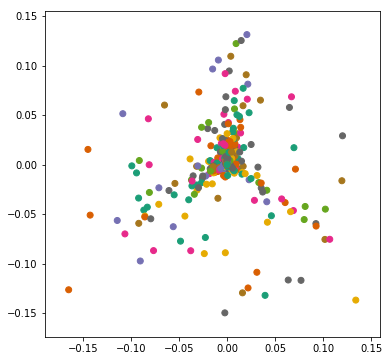

0.18596278
epoch 1


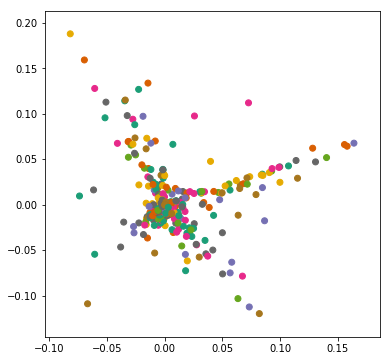

0.17793141
epoch 2


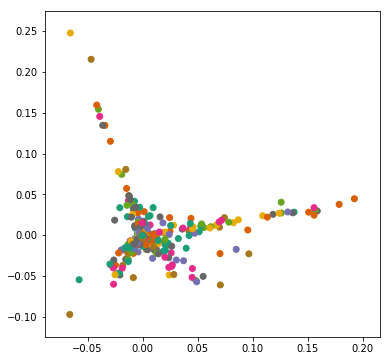

0.21546014
epoch 3


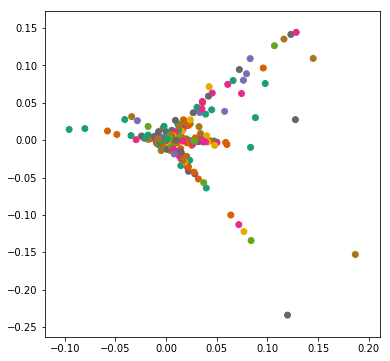

In [7]:
i = 0 
first_comp_ratios_l1 = []
for weight in weights_all_l1: 
    comps = pca.fit(weight)
    first_comp_ratios_l1.append(comps.explained_variance_ratio_[0])
    print(comps.explained_variance_ratio_[0])
    print("epoch " +str(i))
    plot_color(comps.components_[1][:500],comps.components_[2][:500], test_labels[:500])
    plt.show()
    i+=1

0.24385111


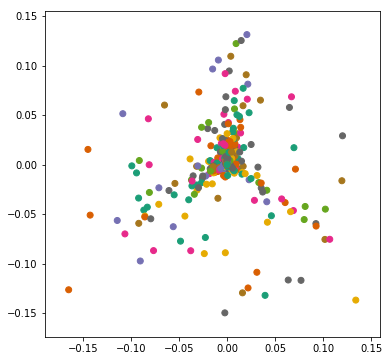

In [8]:
comps = pca.fit(weights_e0_l1)
first_comp_ratios_l1.append(comps.explained_variance_ratio_[0])
print(comps.explained_variance_ratio_[0])
plot_color(comps.components_[1][:500],comps.components_[2][:500], test_labels[:500])

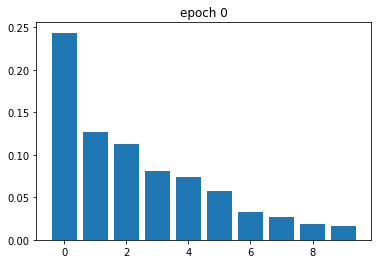

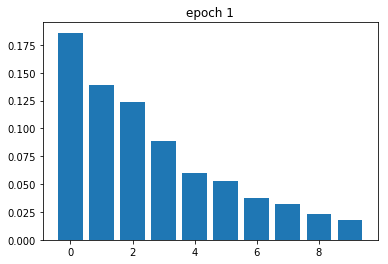

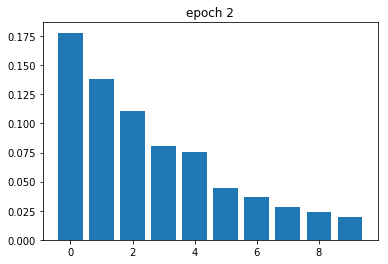

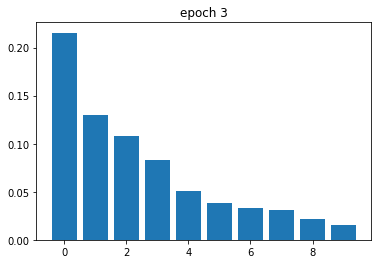

In [9]:
#TODO: show the distribution of PC's across an epoch
i = 0 
for weight in weights_all_l1: 
    comps = pca.fit(weight)
    plt.title("epoch " +str(i))
    plt.bar([i for i in range(10)],comps.explained_variance_ratio_[:10])
    plt.show()
    i+=1

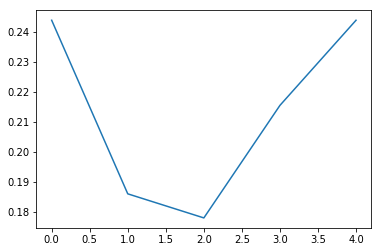

In [10]:
# How much does the first PC explain across all the epochs? 
plt.plot(first_comp_ratios_l1)

Looking at the graphs in the cell above, this evolution makes sense. The final scatterplot of the first 2 PC's look like more disctinct components can draw from. 

Why is it that the 1st PC starts to be the dominant one again? Maybe take a look at the train/test accuracy across those epochs, maybe can see that overfitting. 

#### Variance across the epochs
It makes sense that variance is increasing. As the model learns to differentiate the inputs, activations will vary more and more to distinguish them. 

In [11]:
"""
    Given an [#epochs, #neurons, #inputs] matrix, creates an array of variance for each epoch. 
"""
def calc_varaiance_across_epochs(all_weights): 
    variances = np.array([])
    for w in all_weights: 
       #print(np.var(w))
        variances = np.append(variances, (np.var(w)))
    
    return variances

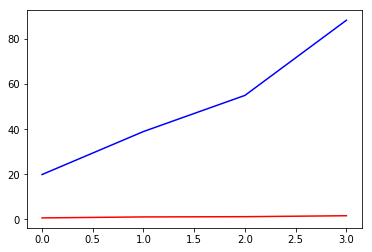

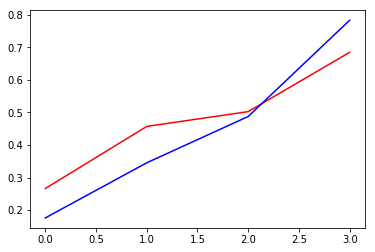

In [12]:
plt.plot(calc_varaiance_across_epochs(weights_all_l1), c='red')
plt.plot(calc_varaiance_across_epochs(weights_all_l2), c='blue')
plt.show()

v1 = calc_varaiance_across_epochs(weights_all_l1) 
v1/=np.sqrt(np.sum(v1**2))
v2 = calc_varaiance_across_epochs(weights_all_l2) / np.sqrt(np.sum(v1**2))
v2 /= np.sqrt(np.sum(v2**2))
plt.plot(v1, c='red')
plt.plot(v2, c='blue')
plt.show()

### Layer 2: 10 neurons, last dense layer

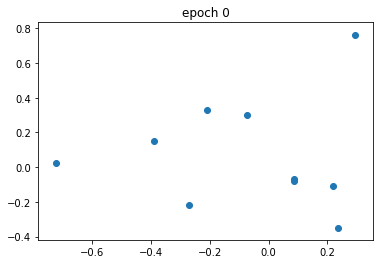

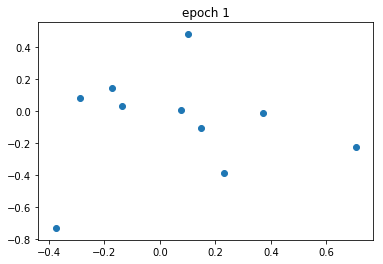

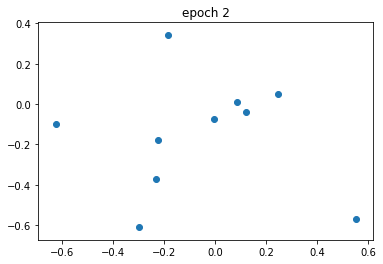

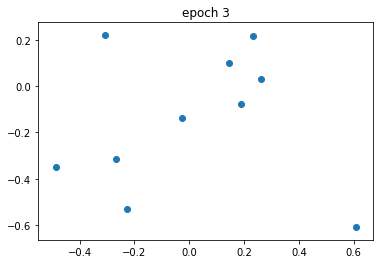

In [13]:
i = 0 
first_comp_ratios = []
for weight in weights_all_l2: 
    comps = pca.fit(weight)
    first_comp_ratios.append(comps.explained_variance_ratio_[0])
    plt.title("epoch " +str(i))
    plt.scatter(x=comps.components_[1],y=comps.components_[2])
    plt.show()
    i+=1

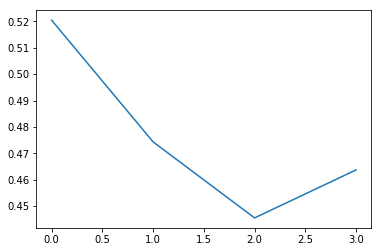

In [14]:
# How much does the first PC explain across all the epochs? 
plt.plot(first_comp_ratios)

## Wassup with Clustering

In [15]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(weights_e0_l1)
clustering.labels_[:5]

array([-1, -1, -1, -1, -1])

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for i in weights_all_l1: 
    clustering = KMeans( n_clusters=10).fit(i)
    print(silhouette_score(weights_e0_l1, clustering.labels_)) 

/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.2921855


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.30727008


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.18872653
0.22562274


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


I mean we have the labels, we just wanna see a general overview of where they're ending up. 

### Silhouette Score
s(i) = (b(i) - a(i)) / max(a(i), b(i)). 

Where b(i) = average distance of point i to all points in nearest non-member cluster.   
      a(i) = average distance of point i to all point in the same cluster.   
      
A score close to 0 means the clusters are relatively overlapping, or b(i) = a(i). This is fine usually but likely because of curse of dimenionality, these values are roughly equal when you wouldn't expect them to be. 

The values seem to be getting closer to 0, which means the distance within a cluster is increasing, supposedly more than the distance between clusters. 

Since the variance does seem to increase those, I suppose that means that this makes sense. Maybe if the clusterings get too far apart, that might mean overfitting? 

In [17]:
print("Silhoutte scores for layer 1 ")
for i in range(len(weights_all_l1)):
    print("Epoch ", i, ": ", silhouette_score(weights_all_l1[i], test_labels[:500]))
#silhouette_score(weights_e0_l1, test_labels[:500])

Silhoutte scores for layer 1 
Epoch  0 :  0.18551622
Epoch  1 :  0.17216104
Epoch  2 :  0.12752427
Epoch  3 :  0.12476246


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [18]:
print("Silhoutte scores for layer 2 ")
for i in range(len(weights_all_l2)):
    print("Epoch ", i, ": ", silhouette_score(weights_all_l2[i], test_labels[:500]))
#silhouette_score(weights_e0_l1, test_labels[:500])

Silhoutte scores for layer 2 
Epoch  0 :  0.27633244
Epoch  1 :  0.27169803
Epoch  2 :  0.21944462
Epoch  3 :  0.21016367


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [19]:
print(silhouette_score(weights_e0_l1, test_labels[:500]))
print(silhouette_score(weights_e1_l1, test_labels[:500]))
print(silhouette_score(weights_e2_l1, test_labels[:500]))

0.18551622
0.17216104
0.12752427


/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Things to try: 
    - Precompute with silhouette: cosine, pearson
    - Create similarity matrix and use MDS to project into 2D

### Silhouette Score with Cosine Similarity
The values don't seem to be changing too much to be significant, or are even still decreasing. 

In [20]:
print(silhouette_score(weights_all_l1[0], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[1], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[2], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[3], test_labels[:500], metric="cosine"))

0.35114563
0.36166364
0.33993635
0.32191855


In [21]:
print(silhouette_score(weights_all_l2[0], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[1], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[2], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[3], test_labels[:500], metric="cosine"))

0.47172144
0.48172772
0.48462743
0.47328892


### Silhouette Score with Correlation
Seem to be approximately the same as cosine, and similarly unhelpful trend/insights> 

In [22]:
print(silhouette_score(weights_all_l1[0], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[1], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[2], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[3], test_labels[:500], metric="correlation"))

0.3511336793295797
0.3615071579522062
0.33934156770748497
0.3208784155340445


In [23]:
print(silhouette_score(weights_all_l2[0], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[1], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[2], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[3], test_labels[:500], metric="correlation"))

0.4809350999755804
0.49051042116305826
0.49376122076364554
0.4809274379542611


## Projections based on dissimilarity

In [24]:
""" 
    Makes an [n, n] matrix of dissimilarity scores from an [n, m] sized matrix where n samples has m features. 
    Possible metrics: 
        1. cosine (defualt): 1- cosine similarity
"""
def make_dissim_scores(samples, metric="cosine"): 
    sim_matrix = np.array([])
    if metric == "cosine": 
        sim_matrix = cosine_similarity(weights_e0_l1)
        # Some rounding errors I think, but manually set the diagonadata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX8AAAD8CAYAAACfF6SlAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzsnXdgVUX2xz9z730lPSQk9BJ6B5EiAlIEwYaKHXv9qeuuXSxrX8u69l07FlQQRUVROggISJXea4AUSEgvr9wyvz+CIcl7gQAvBbmfv3i3zMwN7507c+ac7xFSSmxsbGxsTi+U2h6AjY2NjU3NYxt/Gxsbm9MQ2/jb2NjYnIbYxt/GxsbmNMQ2/jY2NjanIbbxt7GxsTkNsY2/jY2NzWmIbfxtbGxsTkNs429jY2NzGqLV9gAqo379+rJly5a1PQwbGxubU4o//vjjkJQy4VjX1Vnj37JlS1atWlXbw7CxsbE5pRBC7K3Kdbbbx8bGxuY0xDb+NjY2NqchtvG3sbGxOQ2xjb+NjY3NaYht/G1sbGxOQ2zjb2NjY3MaEhLjL4QYKYTYJoTYKYR4rJJrrhJCbBZCbBJCTAxFvzanF37dwLSs2h6Gjc1fgpOO8xdCqMC7wHAgBVgphJgqpdxc5pq2wONAfylljhAi8WT7tTl9WLc7jZcmzmNXWhaaqnDhWZ14+MpBhDkdtT00G5tTllDM/PsAO6WUu6WUfmAScEmFa+4A3pVS5gBIKTNC0K/NacC+jFzuefsHdqQewpISv2Eybflmxn78S20PzcbmlCYUxr8JsL/M55TDx8rSDmgnhFgihFgmhBgZgn5tTgMmzPsDv2GUO+bXTVZu209KZm4tjcrG5tQnFMZfBDkmK3zWgLbAYOBaYJwQIjagISHuFEKsEkKsyszMDMHQbE51dqQewrQqfp3Aoansz8yrhRHZ2Pw1CIW2TwrQrMznpkBakGuWSSl1YI8QYhslL4OVZS+SUn4EfATQq1evwF+8zQmRn1PEwunryc8tomvvVnTtnYQQwd7ZtUeR188Pi9fz2/o9JMREcO3QM+ia1IiuSY3YlHwA3Sy/0evXTVo1iqul0dY9PMYB9uR9QY53DZHOJJJibiba2a62h2VThwmF8V8JtBVCJAGpwDXAmArX/EjJjP9zIUR9StxAu0PQt00ZpCx5X5Y17BtX7eGp//scaUl8Ph23exFdeyfxzLs3oGpqbQ21HAUeH9e9PIHM3CJ8uoEQsGDdLsZeM4QxQ89gypINGB5/6XLS7dA494w2NKgXVavjPh48Rjqm5SHC0RIhQhthXaTvY0na1ZiWF4lOvn8T6UWz6dXgv9RznUF60UxyfRuJdCTRJPJiHGp0SPu3OTURfxqMk2pEiAuAtwAV+FRK+aIQ4nlglZRyqiixRq8DIwETeFFKOelobfbq1Uvaqp7lyc4sQFEFsXGR5Y4XFXr58KVfWDBtHaZh0q1PK/729CU0ah7Pdee8RF52Ubnr3WEO7v7nKM4b3asmh18p42YsZ9yM5fh1s9zxMJeDea/eRXp2Pq9/t5DVO1KIcDu56pzu3DKyD5pa99NUivVUVmfcT6G+G4GCpkTQPeFl6of1O6l2PUY6hzy/o4owUgunk+n5DSi/OnKrjQDQrVxM6UEVYSjCQb9GXxHpbHVS/dvUXYQQf0gpj/njDonxrw5s41+CZVnMnLyKL96eRWG+F6EIWrVvxNjXr6Fx83iklDxw9Xvs3paO7i9vPCOi3Pi8OkYFowrQuWcLXptwV009BgBLNu7hs1krycgt5Mx2Tbnjgr40jo/h+pcnsnnfwYDrw5wOrhzUjd7tm3NWx+aoSt039mWR0mJBykg8xgHKGmZVuBnY5EfCHU1PqN2dOR+xM+8DBCqgYMqiSq4UCBQkZrljsa7unN34qxPq26buU1XjX2f1/G3A0E0ev3UcG1clHzlowo5NKTx83Qd8Pm8su7eksXdnRoDhBygq8Fbadk37/Cf/to43v/8Nr78kcic9O59f1+zk6yevIzYyLOg9Hr/O1/PX8N1v66kXGcanD19NQmzJqmd7SibfLFhLenY+/Tq14LL+XYkMc9XY81SFLO9K/GYuFWfkljTZV/AdHeLuP+42c30b2JX3EZb0V+FqWcHwlxzL823AtDyoSvC/u83pgW38axjTtNj0RzL5ucV07tmCevWjMA2Tad8sZ+a3KzEMkyEX9+CymwYw98c/2Lp2X0AbUoLX42f5/C14PX5kQHDV0XGHORhxRe9QPdIx8esG70xZXGr4AUxLUuT1MealCRR5/QgCQ8QAdMNCNyx8usHT42fx/n2XM2/1Dp4aPxO/YWJZkrU705g0fy0Tn7iemAh3jT3XsfCZwSPWJDoeo2JMRNVIKZiCWQXDr+BEApJg1woQdWO/x6b2sI1/DZKyJ5PHbxlHYYEXaUkMw+Sym/qzec0+tq7dh3U4pHHie/NYNHM9hm5iGMHlDPw+g707DrB03hZ8Hv2YfTudGqZloTlUevZvx5CLe4T02Y5GyqE8grkXLQn5xb5yx5wONcD3DyUviz92pJBX5OWFCXPKvUi8ukFWfjFfzFnF3y8dEPoHOEFiXd2CzLxBFWEn7PM3pY+KKwkAgQZIVBGOhZ84d28itBbsL5xcbpUg0EgI648qnCfUv81fB9v41xBSSp668zMOHcwvd/y7TxYFXGvoFnu2BfrAy6IogjlTVpNVob1gOJwaN91/HoZh0bV3Eh26N6tRt0+9qHAMs2qaPIoQhDk1PH4j4JxpWdz2+jcUegJns37DZMG6XXXK+Ec4mtM44gLSi2ZiSg9QMiN3qw1oHHE+AMX6fnblfkKObx2Rjpa0jr2dGFfnSttsFDGSA0WzS9v7EyFUBjSejM/MIkxrTLijCYZVTJ5/EwX+bUhpIYSKS61P1/rPVd9D25wy2Ma/hti1OY2szIKQtac5VPJzizGPYVRdbgf9zu3E6FsGhqzv46VeZBj9O7dkyaZk/EbgTLgsXr9x1Cie3enZlZ6LCq9bPn+ArvWfo567J3vzv8aUxTSMGEmrmJtRFTeF/l0sSRuDKb2ASaG+kwzPIs5MfIuE8OAvsYSwASSGDyKjeOHhF4CKIjQ6xo0l0tmKSI5E8WhKOP0afUmObw0F/u2Ea82oH9Yv5KGmNqcmtvGvIYqLfJhB3BkniqfYT1hY8KV7eIQLT7Efl1vj/Kv6cMuDta+m8cLNI3lq/CyWbNyDpip4/DqVBZpVXCU4VRW/aVZ6PUCYU2PM0DNCOOLQIIRCs6jLaBZ1WcC5rdlvYMpijux2SCzpZWPW8wwOmxV0dSaEoEfCf8jyLudg0TxUJYKmkRcT6WxdSf+COHdP4tw9Q/hUR0dKyc7CLazLXYEpDfL0bPYW7wQpaBzWnMGJF9ApukedSzQ83bCNfw3RrmvTUp9+SJAlG6kVcbkd3HjfcC669iwUVakzP7Bwt5PX/+9icgo95BQU89nMFUxbsfWY99WPDqd9s0SWbk4m2J/PeThR7apBPRje89TKaM32/UGwbW6vkYlu5eNUY4LeJ4SgfthZ1A87q5pHePxIKZmw9wPW5C7FkIF7UdsLN7K9cCNhSjh3tXmM5uGtUeyVSK1gG/8aoqjAS/2G0Rw6cGwffVWxzPKGQyiCmLgIho/uVWeydytSLzKMyDAn89ftqtL1YS4nQ3q0YfWOlIB9AJemckn/LtxxQV/ioyOqY7jVilOph2EVBhwXQpyyYZg7CzfzR85irCCb0mXxWMW8uf1pIrVoLm1yPb3jas8tebpiG/8QYugmS+dtZvOavTRoEkvLtg1RNZXZU1axcNp61BBnpMqKU2EJV94+iLDwmo/k8PoNVm3fjyUlvds3K9Xa1w2T39bvJj07n47NG9CzbRNyCz1VKsqiqQpndWzO8J5teeO7hQHnVVXhb6POJiq87oR3Hg9JMTezNfs/h33+JSi4aBxx0SkbjbMsa8ExDX9ZCo18Ju37mAg1ik4xNReBZmMb/5BRVOjloWs/4EBqdrnQS82hlmbYBgvILHs+GBHRbooLvEf1d/+JlJIPX/6FWd+t5JXxdxARWTNGccmmZMZ+/Eupi8myJC/dej5tmtTnlte+odjrRzcsNE2hfdME3r7nUhRFgSBhkH+iqQqRbie3nd+XqHA37/3jch7+6GeKvSWRPuFuJ/+586JT1vADNI+6imIjhb35E1FwYEk/ieHn0Dn+idoe2gmTrx+/0qohdb5I/h+vdB9XDSOyqQxb3iEEpCYf4t+PTGLHxtSQt33RtX2Z+9MavMVVyegsweFQOe/yXtz7zKUhH09Fcgo9XPjkuHJx9wBCQFKDOJIP5mCV+Y65HCo3DuuFUASfz1oZEP0THe4iISaSvh2bc9PwXqUZvVv2HeSjactIy8qnd7um3HfZOTgcddO1dbzoZj5Fxl7cakPcWkJtD+eEMSyD93a+yK6iY+/lBCNCicInvahCpUdsX0Y1HkOkwxahO16qKu9g77ScJAunr+PuS96uFsMP4HA6uOK2c3CFVb1koa6bzP9lXbWMpyLzVm8PelxK2H0gu5zhB/DpJlOXbeaqQd0DtjoF4HRoTHzyOh6+cnCp4f9kxgquf3kiC9fvZkfqISbOX8vwxz6kKEi8/6mIQ40m1tX1lDb8AF8k/4+9RTtP+P4iqwBD6vgsLyuzF/H69n+iW3+N/+O6iG38TwKvx89rYyejB0lIChXN2yQy5u6h3HTfeURGhyEExMRFMPii7jhdlXvtrComVZ0sRV4d/Rix+xXx+nVem7wg4LgEijx+lmxMLj2WU+jhvZ9/D3hR5Bf7eHr8zOMer031kO3PZFP+agxC81uwsMjxZzH7wI+lxwr0PApOwK1kExzb538SLF+wBeM4Dd9xIeCsIR2xTIuVv23DMEpi3QvzPfw+dzO3PDSSnycsJW1fVrmIQVVT6Hdux+obVxn6dWrBe1N/xzyK/74iRR4fc1fvCJr16/HrvDRxLrGRbnq0bsKSjXuCSkNAyV6DTd0gw5uOJhxBwztPFInF3INTkVhsyV9HujcFASS6GnNTy7/TMOzEVFFtSrBn/idIcZGP8W/OrtY+rr1rKLHxkSycsZ4ta/aV+v1Nw8Lv1fn8zVk89c71xMRG4D6c8OUOdxJXP4rbH72wWsf2J+2aJnDemcHj6xUh0FSFMKdW+hnAsORR5R4O5Rdzzzs/sC8jB+dR/Pp1db/qdCTR3Sikhv9PLEzmHPyJFE8ypjQwpEGadx9v73gOn1m5aq3NsbFn/ifI6499S0Za6AuICyGIT4zmjscu4JyR3QBYMG0d3iD+bVVVOHQwj0/nPMKCaevYvyuD1h0bM3BkV1zuqu8RnCzP3zyClKw8NuxOL+fjdzpU3r/vcjbtSefXtTtZs7PqSpa6YTJh3moeuHxQpYqf/Tq3POmx24SGOGcCnaPPYHP+WvQqyU2fHIbUWZO7jLPiB1d7X39VbON/AhTkFrPyt23H1NU5HhxOjXMvOYMeZ7UhMz2X2LhIpJQIISo15FKC0+UgPMLFBVf1CdlYguEzdRyKGjQbUwjBB/ddzuuTFzJ16SYMy6JZQixPjjmXBrFRPDz7ZwrLlGGsCqYl2ZGayb+/+RVNVQJq+EaFuXjm+uEn+VQ2oeTGlvcyLf1blhyah9/y0jKiLQPqD2dq2kQ8ZjF+y3fsRqqI3/KR4z8UsvZOR2zjfwLk5xajqir6cfi5j0WjZnEsnbeZhdPX4fcZOBwarTs14sVxt3H+lX1Y9ds2vBWkmx1Ojc49W4RsDMFYfmgHr26eSmpxNk5VY3SzPtzbbiSaopKenc+3C9exOy2Lbq0bcc+os3n06iHoplma5PXgB1PJKfAERP0cC4eqEhsZzuxV2wMMv8uhMf2l24hw1z0ht9MRS1osyJjOgswZeMwiWoa35bKmN9A4rDkAPeudTapnLzn+Qyw7NJ+thetRUIl1xFGg5+GtoFBaFVRUmocH1zOyqRq28Q+C36ezdN4WMtJyaNe1Kd36tCqnkdOwaT00hwrH/52tlNTkQ+VWEqbhZ8fGVL77ZCHX/W0Yo64/mynjl6CqCkIRKIrg+Q9uqlYZh815KTyy+iu8VslLx2vqfL9vBQW6h9FRA/i/t75DN0x002LFtn1MmLuarx6/jsbxR2Kzl2xKPm7DLwS4nCq5hR48/kA/sqYqbN6bQe/2zU7uAW1Cwg8p41mevbB0Zr+9cCNvbX+GRzu8Qn1XAxSh0Cw8iWbhSXSLLV9EKF/P5blN/zju/QK3Gk7H6O4he4bTEdv4VyBt7yEeuu5DfF5/yQzcqZHUviEvf3p7qftF1VTuevIiXhs7OWT9BnMh+X0Gc6as5rq/DeOWB0dywdV9Wbd8FxGRbnoPao/TVb1+/c92zcdnlf9R+iydWenrWTeliGLfkXM+3UQ3LN6esoh/335ks1lTlSqHgmqqgkNT6d2+GZf268zDH/9S6bVWFeQhbKqfIqOApVnzA4y3bvmZc/Anrm1+51Hv95jFJa7E49y7H5J4IXMO/sjK7JJ6GH3iBjEk8QIcyqkpi1Eb2NE+Ffj3w9+Ql1OEp8iPaVh4i/3s2pzGtx8vKHfduaN6ktg4ttrHU9bINWhSj/NG96L/eV2q3fADJBdmBv1NapZK8sGcgOOWlCytEH45sld7HFVcnfTvnMSSt+7lrbsvYdLCtZWqoEop6dGmSZXatKleMn0H0ETgd9HCYl/RscX7ElwNcQS5/2g4hJN1ucuZfeBHMn0HyPQdYFb6D7y93Y4AOh5s41+GvJwi9mxLDxBM8/sM5v64OuD6p/57PapW/k+oqgqKWrmMsqopuMIcVEVp2eHUjlpuccXCrdx54Rtc2OUJbhj8MjO+XRHS8McOMU1QCByoIc3SsM2KuCu8lB64/BzaNI4nzOXA5dAIdzlwaGpAq26nxrVDjjzrhj0HKh3XMzech8thL1rrAnHOhKAuG4GgofvYL2hFKFzV7HYcwokI8l0ri0M4CVcjGNlwNAd96eX6NdDZ79nNExvuYErKl1jSXhkeC/sXVAZpSSr7/v05C01NPsSnb8xk/YrdREa5ueSGs9m6dh+7tqQTGx/J1f83GJ/Hz2dvzMLQzdL7FEWgOVTue340/c/rwpO3fcKm1XsrHUtYuJNGzeO55s4hJWOTkk1/JJORnku7Lk3JSMvlpfsn4vOW/AAOHcznw1d+wevxc9lNJ1bKUErJpr0HycgtpFPzBtzaeggLMzbjNY/8yFzCwfDoHuR0Vvh9U3K5zViXQ+OKgV3LtRkZ5uKrx8awZmcqu9OzaNkwjkZxUdz7vx/JzC1EEQLdNLn7on706dD8yH1uJx5foFFxaipDerQ5oeezCT3Rjli6xpzJxrzV5UI8NeFgWMNLqtRGj3p9iXclsiBjOnuLd5DlO4RVIZjCIZwMb3gpwxqMYvaBKfit4DN8QxosOTQXp+LiwsZXnfiDnQaExPgLIUYCbwMqME5K+Uol110BTAZ6SynrnGpbbHwkTZMSSN5+oJyKpsOpMeSiHmSm53LfVe9SXORDWpLCPA/Tvl7OiCt68frEu8u11e/cziyZs5Gsg/lIoH6DaAaO6EpCoxJX0e2PXsBjN48rNd4ATpdG2y5N6dqrJe27NaP3Oe1RNZXsjHzG3vxxab1e07RwurRy9wL4PDoT35vHqOvPPm756EN5Rdz9zvekZeWXGGTD5OJ+nfjwwjt4e+sMNuWl4DwYgWd1GLNkKoZh4nRoqIqFqioYpsmALi25ZWRgyKkQgp5tm9Kz7ZGMzB+euYkt+zLIK/LSpWWDcuqc3y1aT3ZBcUA7LofGZQO6HLXMo03Nc32Le/gx9SuWZS3AlAb1XQ24stmtNAmreiRas/Akbmj5N35Jm8Scgz8FnDeliUM4UIVKrDMep3Dhl8FDR3XpZ2HmDM5vdIVdKOYonLTxF0KowLvAcCAFWCmEmCql3FzhuijgH8Dyk+2zOhn7n2t4+PoPMXQDr0fHHe6kcbN4rrlrCF+8PRufRy/nFvJ5dWZMXsmYe84lpt6RgiINmtRj9M2VF6jo0L05/3znOt57YSoHU3NwujQuvPYsbr5/REkkURleffQb0vdll9sU9vuCa6h4PTrFBV6iYsOP67kf+2QayQeyMcs827TlW+jUvAEfDLiDrfszuPWXb/CWqR4mMWieGMvdF59N2yYJNE+s+h6IEIJOLRoEHM8p9PDa5AXlxvEnZ7RuzAOjzzmu57KpfjTFwRXNbmF005swpI5TOfEQ3KZhSbgUN74KM3uH4ih9mZwRexY/pX51NEVw/JYfUxoop2hdhJogFDP/PsBOKeVuACHEJOASYHOF614AXgUeDkGf1UaLtg0Y/+tYFk5bx8HUHDp0b0bvQR1QVYXNa/YG1fJxOjX278ogplfScfXVa2B7Pp39CD6vjsOpHta4L09BbjGbVu+tckKZy+0gPOr4NO6z8ovYsOdAgMH1+g0mLVjLZQO6MnHe6nLyy4rPxHmwiOwd+RR07kCTbicec30or4gpizew52A2DlVFUxT8QX7ZDeOiq7x5bFPzKELBKU4u96Jr7JnEpMeR5c/AlCUTDU1oJLoa0TaqMwBuNYy/t32a8Xve4aAvnWChQvWc8XbkzzEIhfFvAuwv8zkF6Fv2AiHEGUAzKeUvQog6bfyhpAD6+UEyZpsmJbBrc1pAFIruN0hsXO+E+zuaFIPPp6MoVavD6wpzcM1dQ47b5VPs01EVEbTYTNHh4ilp2fml8frOHD8xG3IREoSET//1C4unrOGlT2/H6Ty+r9TmvQe5863JGIaF3zBxagq6EfiiU4Q4qs6PzV8DVWg80O45pqV/y5qcZQgh6F1vAOc3urKcC6dJWAue6PQ663JX8GXyuwGSEkVGId/u/4QLGl1JpGbXBAhGKBxiwSxTqXUUQijAm8BDx2xIiDuFEKuEEKsyMzNDMLTQcuVt5+CoYNycLo3ufVtXW9hnfGI08YmBX15NU+h9TjsaNYsDSvYrbnlgJJffcvy1UJvExxAZJFtWUxUGdy+Z0fft0ByXQwUpidmch2KVGH4A3Wuwc1MaMyevOO6+n/1yNsVevXRV4TesoOGlTofKqH6djrt9m1OPcC2SK5vdykvdPuLFrh9yadMbcKnBV7PdY/twX7tn6BjVHVVoCAQCSVtHOjHeL5mbfDN+M/QaXH8FQmH8U4CyqZZNgbIKXlFAF2CBECIZOAuYKoQIqDQjpfxIStlLStkrIaHuFbZIat+Ip/93Aw2alGT4OpwqA0d25Yk3x1Rbn0IIHnrlStxhThzOkpmvO8xBXGI0D71yFZ/OfoTpm1/i68VPcskNZ5fLRK4qiiJ47qYRuJ0a6uFVhtupUT86gtsOb+BeNagHUeFu3MUWwUq0+rw6835ac1z9FhR7ST6QXen5cJcDt1PDqancNrIvnVo0PK72bU4PmoW34vxGV6IKFZcweKT+Zq6L3cPwqDRGhG9GZg5BGntqe5h1jpMu4yiE0IDtwLlAKrASGCOl3FTJ9QuAh48V7VOXyzhKWRLp4wpz1EiyFUBmei4zvl1B6t4suvZO4txRZxAWEVptm70Hc/hmwVpSDuXRp0MzLj27C5FhR/rIzi/m7fHzWPHhUjADvzede7bgtQl3Vbk/j09n0EPvBZV3rh8Twf2jB+L1G5zdqSUN46JO7KFsagXTsvho4wo+37yaAt1HnwZN+WefobSJja+W/pYcmsuUlC+5IHIX/SMycRxelm7Jj2NvcRQd4xqQ1Pyraum7rlHVMo4n7fOXUhpCiHuBWZSEen4qpdwkhHgeWCWlnHqyfdQ1hBDHHU1zsiQ0iuXG+86r1j5aNKjHo1cPqfR8XHQ4z957ETf/uDlAztod5uCCq/tWcmdwwlwO+nVswdIte8u9AFwOjSsHduOCPjVTkMYm9Dy5dDY/7dqMxyzZtF2YuodVv3zJrEtvpUlk6H3wcc4EFKHQMywbh5Dk605uWTWCrQVxqEKiWwrDmn/P24MuQwsSWHE6EpK/gpRyupSynZSytZTyxcPHng5m+KWUg+tijH9lSCnZsnYfK3/bRmF+CJXcTlGEEDzz7o1ExoQRFuHC6dJwuR30G9aZwRcdv9DWszeeR4vEeoS7HIQfzgLu3b4ZN4/ofeybbeokGcWF/LBzU6nhh5JNQK9hMG7TSgAKdR9PL51D9wnv0PWrt3l40XSyvIG5HVWlfVTXwxu7JW7LJzYOYGNefTymg0LDic/SmLd/Lx9sqDzSvNgoZGfBZjJ9lWeX/5U4abdPdVEX3D6pyYd44rZPKMgtRigCQze5+YERJ5xB+1fC59VZPn8LudmFdO3diqR2J+6Pl1KydlcaqVl5dGiaSJsm9UM4UpuaZmn6Pu6cN4UCPTAJq0dCI6ZceD0X//wF23MO4bdKNvo1odAwIop5o2/DpZ6YQyJPz2Zn2m20VbZx5rwb0GVgdFjD8EiWXX1PuWOGpTM9/TsWZs5AExqmNGkWnsQdrR4mXIs8obHUJjXm9vmrIqXkn3d8SmZ6Xjm9nPFvzaZt5yZ0Oc6Y/r8aLreDc87vVun5tKx83vr+N37fnIzb6WD0gK7ccUHfoHH6QgjOaNOEM2yxtr8EmZ4iCoMYflUI2sfWZ2n6PvbkZZcafgBDWmR7i5mZvJ1LWp9YVFeMI46ezb4i9+CNyEp0WoqNIwHNuf4svt73MdsK1iMPx5j9qReUXLSD8Xv+x91tHzuhsZwK2M6vSti+IYW87KIAoTS/T+fnictqaVRVozI1zJoir8jL9a9M5Ne1Oyn26WQXFPPl3D945KOfa3VcNtXP1uxMxi6ZETxcV1W5o0sfNudkoAeR5C42dDZknZzLRSgRxDacTFJ0RMA5BcGgJiWTNsMyeHP702wr2FBq+EucUxKBhYXJ1sJ1/Jjy1V9WKdQ2/pVQmO9BBEmukhLyc4pqYURHR0rJtwvXMezRD+n1t7e44IlxzFy5tVbG8sPiDXh8erkiLj7dYPnW/ew5SminzanP+xuW4zMDs7MF8OY5F9ImNp6k6Ho41MAVYLjmCEk0kBAK/x5wOeGaA8fhzV2XqhHjcvNYr8EAbMhbiccsRpaLWxaAQKLw597B/MxpvLbtSbzmX2+/z3b7VEKHHs0xgmRHuhnjAAAgAElEQVSautwO+p/XpRZGdHS+WbiWd6Ysxusv2WQ7kFPA81/NwenQGFrDKpgb9qTj0wO1hzRVYUdqJkkN42p0PDY1x87cQ0Ert0U6nCS4S/zng5q0Is4VhtfQMQ9fqyBwqxoXJ4UmwqtnYmNmX3YrX2xZzY7cLM5MbMJ17XtQzx0GQKbvYJVrCmf7M1h8aA7DGowKydjqCvbMvxIiIt3c/vD5uNxHtPddbgeNW8Qz/LIza3dwFZBS8tEvy0oN/594/Qbv/rSkxsfTulE8Di3wq2UeLuxu89ele/1GaEGUNP2WSVJMiQSKpih8PfIazkxsgioEqhD0btCUL0dcxSebVnHx1PHcNHsyC1NPLjGraWQMT/QewmfDr+De7v1KDT9A47BmVRagM6TButzjz16v69gz/6Nw8XX9aN2pMT9PXEZediH9h3dm2KVnHlWLpzbw6Sb5xcFnMWlZeTU8GrhyUHe+nr+mnEaPQ1Vo07g+HZsHKnna/HW4q1tfftqzBUM/orUTpmpc2bYrce6S3Jivtq7hlVULkVKiIBjSrBUvnDWcK6ZPJMNTWOo2WnEwhX90P5u7ux1f/khV6BR9BrGOeA75D5YKyJX4/INvFIergXsIpzp2qOdfACklw8d+SHZBoF+yTeN4vn3qxhof05Z9B/nXhLlsT8lEEYKhZ7ThiTHDiAoLbVayTd1jW04m/1oxn1UZqUQ7XdzWqRe3d+mNIgTzU3Zzz68/lssBcCkqzaNi2V+Yh9csv3p1qRorrr6HGNfxKdVWhWKjkKlpX7MmZxFSelGkhQeNii8Ap+Li5pb/oHNMz5CPoTqoaqinbfyribwiL/nFXhrHR6PWQEbhD4s38NrkBeVcPy6Hxqt3XMjArq2qvf/K8Pj1ksLsQTb4qottq3Yx98uFGH6DQVedTffBnU9I88gm9Fw1fSIrDqYEHBcEr+Ee5XDy/tBLGdC4ZbWNSUqJzH8OvfgHFhXFM6swAVMqqMKJBQxrMIrzG11Rbf2HGjvOP4QUFXpJ3n6AuIToUhXNyijw+PjnZzNYvmUfiiJwOx08ce1QhvVsV61jHD2gK05N5YNflnIwp5BmCTHcN3pgrRp+gDBnzbrIJr70PRNf/AHdp2NZkrlf/cbgq87mwXF32y+AOsCB4oKgxxUhsKQMeAEYUpa6i6oLIQQi5lmcETdybsxShhLNXrMlRZafluFtiXT8NSWhbeN/DCZ9OJ+vP5iPpqkYukG7rk15+r83VKrt8/CHP7N2Z2ppbVuv3+Dp8bNoGBdNl5bVq0p50VmduOis01f2+ODeTCb863v8Zcpbeot8LPj2d0bcMoQuA2ytoNrmrIbNSS3cWBrl8ycOpWRlWNbtowpBs8gYOtarGYVfobUCrRUCOB1SOO1on6OwZM4mJn04H79Xp7jQi99nsHXdPl5+6Oug16ceymP97rRyRc2hJMb9izmBLqxCj485f2xn1spt5Bf9NRNJapIVM9YEnd37iv0s+WllLYzIpiJ/7342EQ4napn/pzBV48k+Q3iu77mEaw7CNQdORSEpOo7x511ZrSu2HK+HN9Ys5rJfvuSe+T+xOiPt2DdVQJqpSH0LUgYrh1R3sWf+R+GHz37D5yn/H2roFhtXJZOdWUBcQnmZ4cy8Qhyaik8vn+QiZcmLoSzz1+7kyc9mHN4PkBim5KnrhnFBX3t2eqK4wpyIIFXMFFXBHW6X9KsLNIuKYdqom/nvut9Zmr6PhhFR3NPtLIY0bYXXMJi1bweL0vbiVFT2F+bxzLI5/HfwqBPW+7GkRDn88lhxYD8vrVzAtpxMEsMjubXTmby7fhm5Pi9+y2RtZjrz9+/ipf4juKx153LtFOr5zM+czrb8DdRz1mdogwtp6Y5F5t4L+hYQGqAgo59HCbvwZP9MNYJt/I9CblbwTF5NUyjIKw4w/q0bxaMHqfHrUBV6tTtS7yanoJgnPp0RkAj1woQ59GjThMbxJT5GKSW6YeLQVNtfXQX6jerFO38bF3Bc1VSGjjn+Cmc21UOzqBheHXB+wPFX/1jIkvR96JaJflj357fUZF77YxFP9qlcajwYc/ft5IUVv7K3IJd6rjBGterIN9vXl7qV9hbk8sKK+VjSKs3xlYDHNHhm2VwuSupQ6orK13P599axeM1iDGmw37ObLflruapePr1cWwET5OFQ67zHkVpLhKNzwJjqGrbb5yicObAdapBkJUVVaNIiUHkyKtzNjcN74S5T6lFVBOFuJ9cPOxImNm/NDoLZcsuSzP5jW8k1q3dw0T8/od99/2PwQ+/z6cwVATpDNuWJqhfJU98+iCvcRViUm7BINw6XRqNWidzV81GubHgbXzw/GTPIC9qm9vlm+3p8FUI9vabB19vXHVc7S9L2cu+CqewtKKk5kePz8OWW1QFhpEYZw18W05Lsyj0iQzLnwE94jCIMeeR+Xfr5IceBKSus8vFTnP8ehXr+cY25NrBn/kfhmjsH89uM9RQVejH8JkKA0+Xgnn+OQqukmPhdF/WjVcN4xs9ZRU6hh34dW3DnhWeREHNEGtarm5hBhK0My8Lj01myKZmnPp+J9/DKoMDjY9yM5eimyf9d2K96HvYvQt8LevJt+sesmL6a7AO5fP7UJPZtSUFK8Hv8fPvvH0ndnsbjX91X20O1KYOUEo8RKAkC5ZU4k/Nz2JydQfPIGDrHNyi3IjYti/c2LOOtNUsCNpSDGfnKMKRJbJm8gi0FazEJnDBYCDIMN40cR/brBBZpRcv5YP+9dIzuwQ0t7qm0/nBtYxv/oxCXGM0HU+9nyvjFrP59B4mN6nH5rQPpdEYLAPYcyOb7RevJzCtiQOeWjOjVHqdDY0Tv9ozo3b7Sdgd0bnlYdqH8V9Ll0BjUrRUvff1rqeH/E6/f4Ms5f3DryD41GjN/KhIeFcbgq/vz4SNfoPt1ytoBn8fPoh+Wc9v+QyQ2s+sG1BWEEPRMbMyqjNSAc70Tm2JYFvct/Jm5+3fhUBRMKWkbG8+X511FtNPFrrxs/rduKTOTtwUY/uNBQZAQFsnKgymc16ItLlUjUosOWuDFlBCulP+d+i3BZm8UhtTZkr+Wr/a+x22tHjzh8VQntvE/BrHxkdzy4EhueXBkuePzVu/gqc9nopsmpiVZvGE3E35dzWePXHPM2PaWDeO4dkgPJi1YW+L3lyUF0y/o25FOLRqSkpkb9D7Dsigo8hEXXbMlJE9Vtq3YieEPnLE5XQ72bUm1jX8d4/l+w7ly+kT8poFuWTgUBaeq8dxZw/hw43Lm7d+FzzTwHf4v3ZKdwV2//sj+wlyyPMXlsoarglvV6Fa/IesOHUADikwDC0lKYR4PL5pOzAo3P1x0PUMTL+LL5HfxyyMSKioqSWHRxKgOoKRfXQoKLY3fi0u+V4bU2Zy/hiKjgAit7tWgto3/CaAbJs99Nbvc7NzjN9h7MJfvflvPDcOOLfz2j8sGck63VkxfvhXTshjZuwO92jUFSjaO1+wKDDlzahrREXVzCVmdpBZns70gnSZh9WgX3bjK9yV1bc7mpdsDfPy6T6dJm+rNubA5fjrFJTL70lv5bPMqNmUdpEt8Q27pdCaNI6O5Ze53AT573bJYemDfCfd3Qct2vDbwQlIK8xg+5ZNy53yWSaaniEcWzeDr869hWMNLmHNgCmqZSl83Jz2IMJcii8aT6dnCWk8UC4oa4JVl9vyERqGRbxv/vwpb92cQbGXp0w1mr9pWJeMP0KN1E3q0Dqxedc8l/bn3v1PKRQO5nRp3XXQWWpBQxr8qhmXy7IbvWHBwEw5FxbQsWkU14J1etxDtCDvm/aPvv5DZ4xeUM/5Ot4MeQ7vQqJUtMFcXaRIZzT/7DA04XqyHPoY+MSwSRQgm79gQtAaBpCQ81GPojGh4GYMSRpDq2UeMox71XYe/P44RCPcI5u39gJWFi6i4hSwQxDvr5nft9LEkISTM6ai0WlaE++Tjyc9s25S377mEDs0ScWoqjeOjGXvVEMYMPTFhqbRdB5g/aQkbF285pSKGJiYv4beDm/FbBkWGD6+lsz0/nX9t+L5K9zdp04hX5z5DmzNaIhSB0+1g+E2DeHryQ9U8cptQM6Rpq3KJYaFg/NY1eAydhSlHl47+8zfjVsNpHdnhiOEvw4iGl+NS3YgKonDdYnqjKXVzjl03R1XHad04noTYCPZn5pZbAYQ5Na4a3CMkffTp0JyJT1x33Pftz8wl+UA2LRvG0Tguildve5dFPy5HkypISf2mcfxn3rPEN6oXknFWF4ZuMGHrQrxKhSQ7abIkcxte049bPfaLtmPftrz/x3/Q/TqqpqLUgMieTegZ22sQi9KSKdL9eE0Dh6KW1NsSIsAdVFVUIdiVl02DiEjICn5N5/hEwh3H/p7FuxK4sultfLX3XcoqFK3NXUbzzNYMTDjvhMZYndjG/wQQQvD2PZfyf299R6GnZBPIMC1GD+jKkO6ta2VMPt1g7Me/sHzrfhyqgt80cceYFF2agbiyOUqyj7B3MvDtOMCL177FGwueC2hjR0E6+4uyaBWZSMvIxFp4ihIOpWVzf/9/kvtqFEQFRjZJSuK//Xk+fp24mEMpWXQZ0JHe5/dArSQSylHDAnM2oaVRRBS/jr6dr7etY1VGCm1i63N9+x48sngGazLTTugF4DUMPLrOHZ17syg1OaANTSj8b8glVW5vYeaMALePX/qZnj6Z/vWHoQQpclObhETSWQgxEngbUIFxUspXKpx/ELidkm3xTOBWKeXeo7VZ25LOqbn5/Lp9F4qiMKx9axpElcTpG6bF9pRMHJpKUsN6/LEjldwCD91bN6ZhXO1t6vzn2wX8sHh9eWkJRSJaelC7Hs5ULraIunsvrnyYuO8DYhNiACgyfDz4x3i25KWiCgVDmvSKb82/z7gOZy0sWf958cusmrWWgvsS0AdFgVZ+Kd0ioj7/co/i0WHPYxomPo+fsEg3LTo15bX5z+KqQs0Av9dP3qEC6jWIQXPYc6BTFb9pMmHbWr7dvp4C3UdKYdWTqxQhcCgql7XuRLf4hry4cj6mlOiWSbPIWCaMuIomUTFVbm/sulvxWoE1NVSh8UKX94nQIoPcFXpqTNJZCKEC7wLDgRRgpRBiqpRyc5nL1gC9pJTFQoi7gVeBq0+27+ris2V/8Ob8kvKHAsG/5yzkmfOH0tQVxeOfTsevm0gJ9aLCePPuS+jboXktjxh++n1jgKYQlkDuc8Ofxl8D34UxhH1TgK/4SKWl17f8zMbc/ehlshVXZe3iox1zubd9+RDX6sJT5GXRd8vI3H+IlTPWYFkS9/gsjDPDkWEKuBTQJW63kyc7j+Zfvf5DcZniNZ5CL7s37GPK29O55rHLKu3HNE0+fWIiP707C5BoDo0bn72S0fddVANPaRNqnKrKLZ3O5PI2Xegz6d2g17gUlf6NW7AqI5UCv6/UKWNJic80+HHXZs5u1II/rv07O3IPEesKo9lxGP0/iXclkuoJnNM6hIMwte6FZ4diHdIH2Cml3C2l9AOTgHJrJSnlfCll8eGPy4CmIei3Wth9KJs35/+OzzDxGSZew8BnmDw7/Vfu++gncgu9FPt0PH6dtKx87nxzMv4gxcprmor1e0sxy8yanQpWSxcxCdEkNi+JRbakxaz0deUMP4DPMvgxpWaUMPds3Md1Le7mv3//hPHPflu6ma4cMoi8cy+uidloKwpxT8vjOdeF1M9ykZMRmAvh9/iZ/cXCo/b1xbPf8tO7M/EV+/AV+ynKK+bTJycx58uj32dTt1mYsrvSoknt6iUwbtjlfD3yGpxKoFvQaxq8v345bk2ja/2GpYbfkpJFqcn8b91Svt+5keIypSnLsjU7k5tnT2b6VheWVX4MTuHi3Aaj6pzLB0Lj828C7C/zOQU4WtHN24AZIei3Wpi5ZUdQ6QXLkngdEqWC8rJuWizauIdzz2hbQyMMTvfWjVizs2JugIS4MhumPgvXbp1HP7+3NC3ekhIjyPMC+Myakaj919VvUpBdGPScUmjhnpwDkwEBb0x4h3ZntgoaagsEaDFZlsWqWetYPXc90fWj+OHNaeVWPQC+Yh8TXviO4TcMCsXj2FQjGcWFTEvehsfQGdy0FZ3iSvamLGTwUmBAl/gGZHuL8Rh6pdm/u/KykFKW/i68hs6Ymd+wNScTr2Hg1jReWPErky8YQ9vYI8mBu/OyGT3tq8MSFBH4ZTO6NknDremEaxEMa3AJQxPr5qoyFMY/WPxV0L+wEOJ6oBcQ9FcmhLgTuBOgefPacaWYlhU0HFIiMS0ZsFQyTYucgmKklKRsT8NX7Cepa3NUrWYlGMZePZRbX/8GXbfQTROhgFRA7XbYqFrgUhy8/+QjdGh7pFSFpqh0imnCprzypfUEgt7xbUI+zr2b9/PBQ1+wcfEWImLCGX7jIA7sORj0WiFE+f8LWVKcZduqXUREh6N7/eVeAq5wJ+ffdm7pZ0M3eOL8F9myYifeQi8Op4ZeyQopKz0nJM9nU33MTN7G/b9NQ1KSA/LO2t+5ul03nu17LoObtMKQgZMYp6IyI3kb3+/cCMig1wD4LZOLpo4nKSaOOzr3ZkHqHjZlZ5QKzRUbOh5D5+8LfmbmpbeU3ve/dUvLidGl5caRlhtHmKaw7Kp7SPftZHr6ZKIdsfSsd3aN+f2rQiiMfwrQrMznpkBAeqoQYhjwJDBIyjJ50mWQUn4EfAQlG74hGNtxc16Htoz7fRVmBZEpRQgiLBU/gcajqebkjq4PciA5A0VV0Bwaj35+L2ddVLVkr1DQrmkC3z11E5MWrGHLvgzaN0uApGJm567Ba/rp26At/2h/Pk3CA8tQPt75Mu5c/hG6NNAtE5ei4VQcPNCharrkRYaPdE8ODd2xRDoqz0A+uDeTf/R7Ek+hB3nYkP/w1jSMinsVh4mKj6QorxizwnlfsZ8GzRMwDRPdr6P7DDSHSteBHRl1z4jS6375YDbrf9tSmuRVmeEHaN29ZZWe1aZ2KNR93P/btHIROaZpMHnHBka2aEe/Rs35d/+RPLZkZulqVlMUTMsi11+1QkmbsjPYnJ3BvH07iXA4AxRGJSUz/dUHUzGRtK+XwJrMtKCrCU1ReH/XS2TpKfgtHw7h5Oe0r7mnzZO0jAj9pOpECIXxXwm0FUIkAanANcCYshcIIc4APgRGSikzQtBntbBk4x5e/34h6gGDcAX0KLAiQVM17hvUj98W72RHSmaprEOY08HQ7q14+5q3yErNKTdL/dc1b/DBmtdo2rbRMfvNzy5g1mfz2bc1lY592jJkzADCjkPGYVfaIbbuz6Rp/Rjuu2xgOaXDBwnUTa9Iu+hGfDvwfr7ft5wdBQfoFNOEy5v3pZ7z6LMUS1r8d9tMvtu3DE2o6NLk4iZn8nCni1GD+Dgnvz4VX4XZut+rB107OsOcnDtmIDM+mRdg/AF8Xj8frPkPX73wHct++QOAZh0aU5zvITo+ivzsAj569MsqyTe7wp3c8eoNx7zOpvZYlJoc1J3gMXSm7NpEv0bNubR1J/o0aMq05K0UH07eWp15fJW5/tT0r2j4/8RvmVw7cxJOVcVvWTQOD/4baRSbTqY/A0OWuBh16QcJn+95i2c6/7dO1Oc4aeMvpTSEEPcCsygJ9fxUSrlJCPE8sEpKORX4DxAJTD780PuklKNOtu9QsmLrPh7+6JdSSQVhQXihwhlJzRh7+WBa1Y/j+t49+H7RBmas2IJTUxk9sBsN83Wey/MEuIoM3WT6x3O489Ubj9pv8qb9PDDwKXSfjs/jZ8GkJXz5wmTeXfEKcQ2PnoilGyYPf/gzK7btR1UEEmiWEMMH911BbOSx5Q/KkuiO4e52R09Eyc3MY+6Xv3FwbyZd+ndgbw8/3+9bjs8y8B1eEU1LXU2sM5z/azs84P6ty3cENeR/vuiklHiLfYRFuEnq2pxbXxrD4ikr8BYFLhQz92cxpvld5Y5NfW82i39Ywccb3uCLZ75F9wX/ATvcDpq0bkhORh6te7TklheuoUOf2t2zsTk66w8dCGqQK74QGkdGc0eXPkgpmbTt+OoAlEURCiqgB3ET+SwT3+FiM2nFBTgUBb3Mvplb1ejYoLDU8JelyCzkoC+Nhu5AWZeaJiQBzlLK6cD0CseeLvPvYaHopzp5b+rvAZW1DNNi89Z0mtUr2f13OTTGDD2DMUPPKL3m14mLCLbFYeommfsrSRssw2u3vUdRXlHpbNhb5EP3GXw89ivGjv/7Ue/9ZOYKVmzbX27cu9Ozef6rObxxV2jfrdtW7uTRYc9jGCZ+j59Zn83HUx+8rzWB8COzfK+lMyn5d+5sMyxgdtOyczN2rN6DVaHGsWmYvPfHq2z+fRuHUrPpeFY7eg7riqIoPD35QcYOf6G03z+p2AaA4TfIOZjL1PdnMn3c3EqfJTzSzYfrXrOzfU8hfk3ZVem5i5M6lPvsMw1unfM9GZ7glfjKogoR1G0jgHh3OAc8wQMRjvRl0iq6Hl7TINNThCIUrmjThaiIDNK8QdR5JQESELWFnd1ymOSD2UGP66ZJfpGX+OiIoOc7nd0+qM/aHeGi14ijSz14i33sXL07IHLFNEyWTj12gtuUxRuCvrAWb9yD12+Uqyh2Mkgpeem6twPi6qVP4Jqcje+m8tLIRaYPC4la4Ut+5cOjWDh5abmZvNPtoNeIHrTo2JQWHQMjgDv0acuEve/z8divmD1+AcZR/PYAus/gk8cmHvWaBz66C8Nv4AyBDpNNzZBeVBD0uAKlET9/8sGGFazKSD2mrr9LVRnUJIlFaXvxlCkY41AU+jVsjinlMY0/gCUNFl+chF48A1WNQo1oyOLcofyUNgHdKj/7j3LEkOg6tiu4JrCnPodp0SC4i8WhqkeVUW7YMpGRtw7FHXEkq9QZ5qRhUiJDrul/1D4VVanU9+eoguGuWPClFAlGEJXCEyVz/yEOpQSuYoQucSwI/FEmRSQG9fm36NSMF6c9QYtOTVFUBafbyfCbBvPExMCqWvu2pvLJ4xN4++6P2Lx0O536tcPhPPkIKtWh8soN73Bx5PXc1PbvrJy55qTbtKl+OtRLCHo82ukm1lXexfltkHKQwXCpGu+cczF3dO6FS9WIcrhwqxo9EhrzzuCLqR8Wccw5ulPARz1nQv5jOPQZKN7vkFnXc1ZYCm0jO+FUXCioOBU3YWo4tyY9UCf8/WDP/Eu5Z1R/7n/vpwAZ5VtH9j5m5ay///c2ug7oyNT3ZuIp9DL46v5c8rcRx5xZOl0Oeo08g5Uz1pTbmHS4HZx387ELVp/TJYmZq7ZhVlAYbdU4nsgqSBxUFdWhVRpXLxwKAoFEIgCn4uDhThdX2la3czoxbuOb+Dw+NKcWVItn1ufz+e/fxmHoJqZhMnfCIjr2bYsepDDL8WKZVunKI23XAZ67/DX+8+uzdOxr+/zrMmPPHMR1s74pF+0Tpmk8fObAgOSuyvJWKuI3TQ54Cnmw50Bu69ybX/ZsYcquzezKy+Lm2d9xUVIHZu/dXmmRGKeiMqrJflqFJ4P8c1VsAV7Uwje5o+UC9nqy2F20lWhHPbrF9K5TJR1Dou1THdSGts/C9bt447uFpBzKIy4qnFtH9uGawT2q9U2dk5HHQ4Of4VBqFpYpEQLantmKl2c8eUyNmszcQq57eQKFXj9ev4FTU9E0hY8fuJKOzUOrIX5P77HsXLMHWeZF4wp3cuETF7D3fMH2/DRaRTXg1tZD6BRz4gncRfnFXNXojnL+/T/7MvxmyIuvCwF9LujJv35+PKTt2oSelQdTeHnlArblZNIgIooHevTn4lYdA657bvk8vtq6Ft06+nclyuHkw6GXcXbjFqzOSOO6WZPK1RF2qxqXtOrI1N1bSsJGpSTG5aZdTDw5fi8DGrXg70nf49JnBjYuIhDRLyLCLjjp5z5eakzb56+AlJKPpy/nizmrMEyLqDAXVw/qzpltm6IbJs5qFP6qlxjDuI1vsG7BJtJ3HaRV9xa0792mSi+chNhIvn/2Zn5eupn1u9No1SieywZ0KVcsPlT8c9IDPHDO03gKPZi6iaIqdB3YiTseuTqkwmjr5m9Cc6j4K+hjVczKDRVSwv6tgXVjbeoevRs05YeLrj/mdff36M+ClN0cLC4sV/y9In7LpH1ciTvp5VXzAwrIe02D+Sm7WXXN31ifdZBop4tOcYnlfptW3jzQFYKWiFfqnp5PWeyZP/DpzBWMm7E8QB/HoSk4NY37Rw/k8oHdjtpGdrGHr1etY/X+NFrVj+OG3j1oHhdbncOucQzdYMX0NWSmZNGhTxva9w6erJLhzWPCnsWszUmmWUR9bkgaSPsqll9cOWst/7r6DYrzA9URqwOhCAZefhZXP3oJ3742lbSdB+h2TkeueGgU9RsHJsTZnBpkegr51/L5TN2zJWh+gFvVuK59D57qW1I1rPOXb1IU5EWhCsGqa/5GPXdwQy71Dcis64AKiWQiBhIWI4z1oG8BtRm4BiJE9c+3qzrzP62Mv26YFPt0osNdpW9vKSWDH3qfAk/QpGOgxPf/1t2X0KcS9c60vHxGj5tIsd+PzzDRFAWHqjBuzGh6Na/9eN6aJLU4mxt//x8eU8eQJgKBS9F4+Ywx9E9of8z7db/O5Qm34Skob/xVTT2qy8eKVjH6RSBVgWN5EUpW1cT23OEubnvlOsY9NgG/x4+UEs2p4o5w8/4fr9KwZe3VNbA5MTZmHeTaGV/jPVwIviICuLRVJ94458JSOzD0+4/ZnR9c4qNvg6Z8OeJqnJXs/VlF46HgPyAch1tXIfZ/UPg6GNtBGiXnlFhE3NcItXrrR1fV+J8W0T66afLqN/MZ9OB7nPfYh4x8/GPmrd4BgN8wKfIe3aXg9Rt8MafyF9Hrvy4mz+PFd9g4GZaFRzd48uc5p1TZxFDw3vbZFBk+jMMqoRKJ19J5eeOPx/xbeAo9PH7+i+XCORVFweHSOP/2oQgluOeJxD0AACAASURBVCvMf04kBeNb4rkzAe/t9SkY1wLfqOCSvIqq4I5w4Qpz0nVgR1799Rm+fvkHfMW+0vEZfpPifA+fP/3NCfwFbE6UPJ+X99YvY8yMSTy6eAabs49fDEBKyb0LplKg+4MafijJypm6ZwuP/z4L/+GouH/0OJswNfisfH3WASbv2FBpn0rETYjE3xAxLyFi30QkLuH/2Tvv8Kiq9I9/zr13WnqnBELvndCVDiIoYEHXXlbFddeyutaf6+q6unbddVUUe++NJqKI0kF67zWQhPQ29d57fn9MCElmEgJplPk8Dw/JzC1nJjPvPfc93/f74v3NP+OXTsALsgSMDGTBqbO2dFbk/J/+9BfmrNxWpuTJKijhkffnEh1hJ7VDCxJjwsnMq17PW93zi3fvxwwS2A7lF1Dg9hDjOHVW+OubVbm7/Q6Llcj3lZDjLSbBVnXDm1fvepctS3fg85S7/RbQdVBHLr7zArIO5rBy7lqkcez4ZrSK6+4mfr//crhvTEBb40RNK6fftmo079CM/yz6FxEx/rqNrLQcivOdVMY0TNb+vKHGrztE7chxO7ng+/fI97hxGzpqpmDmnq38Z/hExrWquRIrrbiQjCpqAspjSMl3u7egIPj3OeO4qF03NmRn8s6WwEmeS9f5dvdmru5cdd2OUOLAfsxKRbq+BSpnEwzwrkBKF0KcWAV+fXDGz/yLXB5mr9gaUAzl9uq8OWcFQgjuvnQY9moWLTVVYWCXql1Gw6pqESjA1sDuno1NlKWqD7UkXK1avWSaJr98srhi4McfhNf/toXbUu8nMi6CP9w/mbCoY+fQB4cH95BVBWJcPNGJUTRplcjIK8/h0W/u4411z5UFfoCwKAcySLUwQGR843VmO9uYtmE5OW5nmZTTkBKXofPgkrlBLdarQhGiKmfnANyGzte7N5UVeF3crithVcz+LUH6ABzFlJIvdm5k8swPOP+7d5m2YTkuvapRSKjCWbShOeODf05BCZoa/GWmZRUAcF5qJ56deiGdWyZhs6iUF9poqkKEw8b151WdQru6f2/sWsUPjUVVGNmhLQ5L4/aOlVKycdFWFny2hPQ9wa2T65KrW5+LXan4mq2Kxoikbji0inUPhm6w6JsVPP/HV5l+3wfo1TTF8bq8LP5mBa26tOTTg29gC/MfS6oiuKm4An3P70mztk1AgGbRSOncPKCuIDwqjEET+2GxVfz72cNtXHZP1fUKIeqWnw/sCpqm8Rg6e6vIxQcjOSKKlMiYGhsoCAT5Hv9ibbf4JkTZAu/SwzQLV3XqVeUx7l44m0eX/8z67Ay25WXx33VLuXzFZHxm5e++AEt3hBLcLaChOePTPk3jooIWKAkh6NbqmBb+3O5tOLe73+d+yaa9vDdvFdmFJQzu0oobx/WvVj5548C+7MjMYu7WnVhUFd006dIkkScnBpqbNSRZaTncO+ox8jLyQfj9hkZecQ73vHVbvfnaTG7Rn/0l2Xx5YDlWRcNr6qTGteH/uldsraj7dB4471/sWL0Hd7Hb3//gOFM2d4mHWW/MY8w1w7jv3dt59oZXUNa5K+ssANCkysbHl2Js9Kfrftr3Gz998Bvjbx7FXa9NrdBv4W9v38a/LnuBjYu2YrFZ8Hl8TPrL+Zx3w4havhshakqUzQ5BsjWGNImynljB4msjJ3H5nE/wGgYew8CqqthUjTxPoILMrmkkOfzBWBGCt0ZfwlU/fo5h+r3/BXBB605cWMk/6Cg787P5cf+OCsVnbkNnb7GNn7J60S1uD4uKoygybXSzuxjU8nFOlSTwWaH2eWPmMqb/sDzgIvDMzRMYm3p8BUpNOZRfyPYjWSRHR9OpScLxd6hn7jznYbav3FXBBM0ebuO2F29gwi3167WX73WytziTpo4YmjkCrTN+fG8Br9zxdlDHzuqUPR36tuG1Vc8CcORgNr99vpQl4fv4vU0WJhITiVXRUL7Lxvp64IKhogou/NN53PG/mwOey9h3hOy0HFp1a0lk7KnTdONs4Ps9W3hwyY8VPHY0odA3qTlfTLiqmj2D49Z9/Lh/JxnOIvokNifKauOS2R/j0n1lcwyHqvH44LFc1qFHwL4/H9xNntvFoGYtK3Tuqswn29fxrxW/BK0CHpUSR1z8r+jSQAIWYSXOmsDfOj1Zr5W+oSKvcuimgYLAqDS1fG3mMsb07Vgm98rILSI9t5A2TeNO2BIZIDkmiuSYqDoZc23JSc9jVxAHTXeJh+9fnVvvwT/GGkafuDZVPr/gsyVBA789wobVbqUwO3AaaHVYGXnluWxdsZM5b/2Ms9DFsEsH8cIlF7Dfnc28wxswpEHrrChe//C1oHcEpiGZ8+Z8Usf2ot+43lhtx27Nm7ZOCkk7G4lJbbqwJecI721djVVR0aVJm6g4Xh05+fg7B8GuWZjcrmuFx7678FpeXLuYtUcOkxwRxR29hzCyRdug+1Y1069MoiPcby9hQJfIHDpF5rLPGc2WwqZk+rYRWa43tk96yfVmsyR7PqOa1KxRUn1yVgT/uat2BHX4y8gtJC0nn/iIcB56ew4rth3AalHx+gwuG9aTe6YMr7LStqTYzayPl7Psly3ExEcw+doh9BlcsehJSkmh24PDomHVGvat9jg9KFWsdbiKa9bZqD4pb4RXHmlK3FWML65JDKZhct/ox/C6fUhTsnLOWmZP/4mn5v6dP3X0p9ky7Vl4XFXLd3WvzlPX/BdVUXnky3tIHVt1PrcxkFKS415JvmcDDq0pTcPGoCqNrw6pT4QQPNR/BLd078/GnEyahkXQJa5uL8QdYxN4fdRFdXrM4cltibbAtN5z6BNzBBP/EtTekhjW++IYEnUIQwqWOhNZ547FJ72sL1gRCv4NhRpEHy6aujF6lDBl1fOwNgrzkA3DkHhL0w1fL95ISlIslw0PDAwlxW7uuPR/5GQW4i1tGLJu+S6uu2Msl9w4FICFu/bx2Jz5HCkqRgjBpB5deOT8kdWqiuqSpm2SiIgJw+OsOLu22DSGTRnUIGOojgumjmX1vPUBs3+P01ulnr/H8C68/+gXuBPA6BaJyDeQq0vYumInS75bybApgwFY8/OGCh5EwXAX+8/72CXP8fG+aUSdIsoew3SzMuMWCr3bMaQHVdjYIp5hcLMPiLAGzlLPNBIc4UFn46cqVlVl5qgCHN5MbOqxWX6XqBy6kI1a+lFuaXHSxVbAJwVtiFBPjezAGa/2AbhoSHds5YKuSPCipBZBmIlpSHxpFgyjYrBwe3U+mr8m6PHmfL6SnCNFZYEfwOPy8f5/51FS5GZTeiZ3fDWTQwWF+EwTr2Ewc9NW7v8+iAFUPaEoCve/fwe2MFuZ94493EZC8zj+8EDdzn5Ohv7jenPR7eOx2LSAYB8scB9V95TcnkDxKym4bk3EeV8Tij5sQ0mcycKvlgOwbsEmXr3r3RqPQ0rK9j0V2FPwHgWeLRjSCRgY0onPLGBt1n2NPbQQgJQm0rMU6foWqe8BIMacXSHwA6hClgV+AJti0sueR4pVZ1jiOE4FzoqZ/9Wj+7Ji2wE27En3+9x3dSGPvnK9alFYQUnw9MPKBVv9vWcroVlUdm4+xLtpgXUFHt1gwY49HCkqJiny2GLimp1pvPT1QnYeyiY+Koybxg/k4nO614mTaN/RPXhz4wvMev0n0vdk0md0D8ZcO+yE+gPXJzc9dTVte7XiuRtfC9D3l0cIsFgt2CYk4bKkVSjokqbE+Whzwlf6vVc+f+77gLud6tB9Os7CwCKvxuJQ8feYAcVBkhLvXtx6FnYtuK99iPpHGoeRudeAmYdfr28g7WNB1uzzJoAJ8W3oFNXjuNs2BGdF8LdoKq/deQkb9qazaW8Gb+mzKDk6ubRKsJngqqj/VoSgf6fg1sQxCREIQYB6yDRMomLC2LM+L6hq0aqppBcWlQX/DXvSuf1/35Y1ZUnPLeL5L3+lsMTNDeP61+Yll9GsTRNueeb4ToiNRUFWEVVe5wRomkqbnq24792/8GTRHCiodLOqCMw4jY5TurPwq2Xs33ww4DASEJpAFUpAD2HNopJ63qmT85dV6V2F/9kQjYfMvwuMw1Rw8HTPB6016NsJ6uxZDk2x0il6SH0O8YQ4K9I+4F9Q6tW2OVeP7kvX2ORyj4PSuwhUydEvl6YqhNkt3HHRuUGPNfnacyqoRAAURZCUHEubTk3p06IZWpC8tc8waBN/TPY4bebSgG5cbq/OWz+swFfHvvWnKskdm6FaAqsn7eE2xl47nP7n96Zd79Z4nB68Mvh74ljs5NVJr/LCTdPIyygoe1wC7ktjKPyyLQVftaPwy3YYVySUhVB7uI1RVw6lXa/Wdf/CTpLkiIkoBC6Gh2kp2LWQEqmxkMYRv1dPQIB3gekCEQNlCv7gTZwEHih4Aumr2ieoITkrZv6V+VPHsWxYeQCP6U81KEk+bMOKSclIQSmx0Ktdc64b04+mccEXAbuntuaWBybw5rNzUFUFwzBp1jKex1+/HiEEtwzpz6xN2zC85TTFFo2r+vUiyn4s5bLzUHbQ45tSklPorPL8pxN5mfksn7UaIQSDJqYSk1jRcK3vmB7EN48jfU9m2axcUQQ+r86vXyzB5/ZfHOd/vJA+95/D3iGWsr8bgMjwYX0lA59X4quUivOeF4Xn6niw++c4OhLvtQm0b9ucNtscjLthJAMv6FufL/+EaRf9R7Kciyj27cGQTlThQBEW+iQ919hDO7uRbqqcKwsDkTAP6foafBtA6whqayh8GGRlT7BCZO7NkLQYIRq3+v+sKPIKxprcvby4ZTa7itIxfAociWRC877cN3ooEbaaVRS6nV52bTlEZEwYrdpX7Jy1OyuH5+YvZtWBNGIcDm4anMoVqT0r5PJvfO5z1u85HHBcu1VjwfO3VVikPh354e35vHLH22WSU9MwuXv6rYy5ZniF7fKzCnj5L2+x9LvfkVKS0iWZA9sOYeoVZ1mKqpA0czAH1HxchheLULF+loP1kxxMX8VtVU2l5KY4PJMDeyok2CKZM/LUcVesjJQmWa4lZVLPZuHno50ilgBnK1JKZNYIMNMrPWOB8BtRIu8N2MfMvw/c3wceTIQjYl5B2Krv8X2yhIq8jkP36BQy14VRVJBU1vPzmyNbWHswne+mXoNSgwVXe5iV7v2CFzK1S4zn9SuqL1D508TB3P3a9xVSP3arxhUjep/2gT9j3xFeuePtgIXxl6a+Qe+R3UlIji97LCYxmn988TdM00RKyYPn/Yt9mwJz96ZhcunezoRf1Jzl2TtJskfhTjzALD1QRaVoCrKKP2Gup3oH18ZGCIWksKEkhQ1t7KGEKEUIATHPI/Nu9vvz4wMcoCYhwqcG30lWISSQEqnvBGsqQjSe+KJOcv5CiPOFENuFELuEEA8Ged4mhPi89PkVQojWdXHe2vDztl1klzgrNHv2GgYH8wtYsmd/g4xhYOcU/n3TeJrHR6EIQbjdyg3n9ef2ycHXGo6HlJLP9i1hwoKnOOfHR7hh6ausz2uY11KZhV8uwwymtReCxd+sDLqPoiioqkpRfkmVxz2wKY2xzXrySI9LubXDWMZcdC72sMA7NYEg8dzgjXRahje+9UaI0w9h7Y9ImAvhU8E+CRH1CCJhJkIJrtsX9vFAsOI8JxS9iMxMxSx4tNF6ftR6eimEUIFXgbFAGvC7EGKGlHJLuc1uAvKklO2FEFcAzwB/qO25a8O2zCyc3kB5oVc32J6ZzdB2rRtkHCN6tWdEr/Z4fToWTa2VxPONnT/xyf4luA3/69pSeIg7fn+H6QOn0jm6YTuK6T4jwFoCQBomPm/1Xba6DOzI7rX7gj7XsnPFdpBdB3dk6KWDWPT1ctwlHoQAq8PGxXeMp+OYVP5v3acV1ghsioW/dm74ptohzgyE2gwReVfNNrafD85P/esAAfLdUhm561OkZxEkfI9QGnaNry5m/gOAXVLKPVJKL/AZUDnfMRl4v/Tnr4DRoi6E7LWgdXwsYUHslm2aRqtG6L1rtWi1Cvxuw8vH+44F/qN4TB9v7ppf2+GdMIMn9cNiDZxbCEVh8MTUavedcs+FQRVAFpvG0EsrVicLIbjv3b/wj6/uZez1wzn/ptE89cPD3PTU1QxN6szzfa+ha3QLIjQ73aJb8kLfa2vUTjJEiJogpUS6F2Dm3Y6Z9yek+wd/IZhZgiy4F3xrCQz8lTDTkEX/bpDxlqcuEsvJQPkEbRowsKptpJS6EKIAiAeCy10agPFdO/L8/MW4db2sC5cqBNEOGyM6VG1IdqqS6S4Muk4hgZ1FlRep6p823VO4+M4JfPu/OXjdPgRgsVu4/L7JtOhYfTP35PbNuO3F63nj3g+RUiKEQAi4c9otQZuqCyHoP643/ccFdloamNCBgQk17wQVIsSJIAsf8y/qlub3pXc5WGeB6QHfcqBmvaRxzYbop+ptnMGoi+AfbLpaOYlVk20QQkwFpgKkpFTdOasucFgsPDt5HP/+8Vf25viLsro1S+KJiedhqaJR86lMoi0Ss4oOQa3DG0cfftNTVzN0yiB+/XwJQlEY+YdzaN+nZhfWyX8ZzzkXDWDZjFUIRWHI5H7ENQ20hg4RorGQvp3g+hbK+8dKJ3gW4Q/6NQz8cILb1g11EfzTgJblfm8BVNYvHt0mTQihAdFAbuUDSSmnA9PBL/Wsg7EFxWsY3PXVLJbuOYAi4Gi57p6cPC57+xOuTO3Jg2OrdvSsjuziEn7cuhOXT2d4+9Z0SGqYxcUwzcbFLQfw3cHfcVfKcd/cfnSdnUdKSZHuJky1olXT2u4oHVPb0TG13UmdKyE5nom3nRo+KCFCBOBdSvCq3hN1zRVga3hlV10E/9+BDkKINsAh4AqgcveFGcD1wDJgCvCLbMQCg7eW/s7SPQdw6xWvtsUevw3w52s20i4hnsv7npgHx7ytO7n3u7kI/B2IXv5tGVf368kDY4cfd9+64K7OE4jQ7Hy6fwlO3UPLsAT+1uVCesbWzV3ULxmbeGHrTPK8TjShcFHL/tzZaXyNLgIhKmKaJpuXbKcgu5BuQzoR26Th15lC1BIRiT+EVm0fXjMkOBpe/1InRV5CiAnAfwAVeEdK+aQQ4nFglZRyhvCLWT8E+uCf8V8hpdxT3THrs8hr+H/eJKOoeq132/hYfvjzDTU+ZrHHwzkvTg+4oDgsGm9ddQn9UhpObSOlxJBmnQbl1Tl7+Ovq9ysoZ+yKhfHN+/BQ98Z3CT2dOLQrnfvHPE5Rnt/u2+fVufy+Sdzwzysae2ghTgBpFiGzhlat5z8RrCNQ4qbX/jjUvMirTnT+Uso5UsqOUsp2UsonSx/7h5RyRunPbinlZVLK9lLKAccL/PVN5QAdjAK3h4N5Bby7fDXvLFvNwbz8ardfuGtf0L4Bbp/OjI1bT3qsJ4MQos5n42/v/qVC4Adwmz5mH15Dsd74zWFOF6SUPHzBU2QdzMFV5MZZ6MLn9vH1i7NYMXt1Yw8vxAkglEhE7HQQUSAiCL60WUN8m+psXDXlrDF2K8/Ijm2DGq8dRRGCZlERXPD6+7z4y2JeWrCYC17/gHeXn9yX06x0dyWlZNOWQ3z42TK+n72WwqLAxtKnGmnOnKCPq0JplIpZU5rsKDzM9sLDVS50n4rs3XiAnMO5AYU97hIP37/WcP0eQtQNwjoAkbQMEfMqaF1O/kCyCCmrtjWvD05vD4ETRErJ90s3s2XVIWw5EotN4IqS/mRVOayqyo4j2XgrFSm9tGAJozu2IyVIHcC57VphBKlotVs0JvU49qEwDJNH//09v6/dh9ejY7WqTHv7V5755xR69WgZsP+pQufoFmS6C4NYDkua2KOD7lNfbM4/yP1rP6ZYdyMAh2rl6T5X0yu2VYOO42RwFrmqbK9ZnFd1ZXOIUxchLGAbDOIxZO51nPiCL4AHmXMpxLyK0BomDpxVM/9Xv1/Cs18sIC2rAExQXZLwI6BUcgr2GQbBnAlMUzJv2y5W7TjI9c9+yvB7XuPqpz5myaa9RNnt/HvSedg0DauqogiBXdO4pFc3+pfL98//bSu/r92H2+3DlBK3R8fl9vHIk99hBKmIPVWY2n40NrXiXMGuWrih7UhsasO5Exbrbm7//R2yPIW4DC9Ow0uOt5g7V71LgffUacpSFR1T2wbvVOawlrWhDHF6Iqy9EXFvg9YdsFCVtXOV6NuROZchzYaZBJw1M/8il4ePf1mDp1wzD4m/IYtWBN5yk3lDSkQVC+EHjuTxzmfLyszYth44wr3TZ/GvG8ZxQd9OpLZszg9bduDy6Yxo34auzSpq7OfM24g7SBcwn89g284MunVuTmFuEe4SD4kt4uuko1dd0D6yKW8OvJX/bf+BzQVpxFsjuaHtcC5IblhL5AUZmzGDNDWRUvJTxgampFTfnzj7UA6LZq5GaApjLhtMRHTDumVa7Vbuen0qL019HZ9HxzRM7OE2mrZJ4oJbxzboWELUPX7/n28AMLMvBn3zCewtQbrAPRvCLq+fAZbjrAn++zPzsKhqheAP/iUapYZKLUVR2LjpcEADFo9P56WvFzKmb0eaRkVy46Dq7QuqoiiniPvHPs6mRVsRiiA6MYr73v0LfUadGm3fOkU155X+NzXqGHK9xXjNwAV7j+k77trDe09+zQcz1mLERoCE/3yynKlXDeaqm+uuDqImjL5qKK27tWTmtHnkpucxaGI/Rl99LjZHzazEQ5wmWHqdYPAHcCH1XbVZOq4xZ03ap0lsBN4g3bEkHOvnW4pVVRnSpiU2TcOiKFgUBZumctfwwRzOCK76ycgtwmccv/vWhPN6YLcHpkk0TeGdv7zJhoVb8Hl1vG4fWQdzeGTSMxza1fD2DABblm3nqWv+y4Pj/sWM137E46p5b9z6ok9sGyxBlEx21UrfuKqrh3eu2cP7czf6A7+igKog7Vbe+PJ3du1s2Pc33ZXHXPt20m8Np9t/hzL8hlDgP52Q3vWY+fdjZl+KmXOF35kzWHcuI+Mkjm5HWGqxcHwCnDUz/8ToCM7p3polm/fhLTf7t6gKMkYARtnv0Q47z19yAcVuD/O27UIiOa9zB1rFxfDN7PWk5xYGHD8yzI6mHP9aOnp4FxYt3cHK1fvwev0LvkIIpl6UyvSpKwN6zOo+nRmv/chtL95Qq9d/osx4bS7T7/8Qr8uLlLBpyXZmvTGPl5f9O6iFckPRI6YlA+LbszJnV5mJnV2x0DMmhdS4tlXu9/n0nzEdNn/gL48QvPn6zzzzwrX1Oewy1uXt465V7+IzTXRpsCxrBx/uXcgHQ24nzhbRIGNoLAzTQ4F3M5oII9La6ZRJaZ4IZslnUPQkFczafGuQrm+REbejRJTz9veuOPETCAfYx9d6nDXhrAn+AE/cOJ6nPv2Feau2I4HYCAcPXTkKHArvLF9NdomT4e1bc/PgfsSFOYgLc3DzkIq1ElMnDOSZLxbg9lZswHLjuH41+jCrqsLjD1/E5m2HWbv+ANFRDkYO7cy6n9YHVYEYPoNDu05mBnHylBQ6mX7fh3hcx/JhHqeHw7sz+PG9BUz+8/kNOp7yCCF4ps/VzD60hhlpqzClZGJyKhNbpFb7/hc6vf4Fnsoogqz8hlkollLyzw1f4irnvOo2fehegzd3zeeBbtU3/zmdOVz8AxuzH0WgIDGwqQn0a/IaEdbTx0RRmiVQ9G+Cu3S6ofh/SMckhNoU07seOImFW+sI/x2D1rpWY60JZ1Xwz8kupmdMAn3OT6RPn9a0ahZbFjCGlzp5HijJ5uv0ZbgNL8OTutIjJqVCUJk0pBslHi9vzF6Ox+v34L/+vH5cN/a4BXVlCCHo3iWZ7l2OqYA6prbF5wnMZdvCrPQa3vVkX/JJsW3FTjSLViH4A3icXhZ9vbxOg/9hZx7v7/mN9fn7SQmL57q2w+keU73UTRUKk1r0Y1KLmr/n4y7qz4rpCwKfMAzOObfziQ77pMj2FJHlKQp4XJcmvx3ZcsYG/yLvLjZkP4Ipj0kgnXoaKzJuYlTLn/C3BDkN8K0DoQWxpCxFKOBZjHRcDHk3n9w5PDORnjnIqL+jhNWv5cNZE/zf+mAhn3+zCqREURWk/JXHHpzEkIHty7b57uDvvLB1JoY0MaTJlweWc17TXjzc/eKyC4AQgqtG9eUPI3pT6PQQ6bChVaHbPhGatEpk1FXn8uvnS/E4/TML1aISERPOhAZekIyICccwA2WnQkB0fN01nNhfks0Ny17FbfgwpMne4kyWZ+/kid5XMCypbvOeoy4ewDsfLibN6YWjrq2mSViYjcsvq+xAXj/YVEuVXZvs6gnKAk8jDhR9gSkrqyokullCjnsVCY6Gef9rjRJJcCO3sg2Qwg55t4EsOMmTlLqBFv4LaR+LUAItzOuKs2LBd9PWQ3z57Sq8Xh2vz8Dt9uHx6Pzz6Zk4SwNtvreE57fOxGPq6NIvJnQbPn7KWM/q3EA3ClVRiI1w1EngP8o9b/6Jqc9dS0qXZBKS47jgljFMW/0s4Q0sR+zYrx2xSVEBaRSrw8bk2+suH/najh9x6l6M0gpdiT8N8szm7+u8tZ0Qgg++upsp43oQaVFwaAojBnfgo7enEhnRMH1UoywOese1RhUVPzN2xcKUlNMkAJ4EHj2bqoKmz8hr2MHUBq0HiOpsxSXIYvAuqYuTgWdxHRyn2jOc+cz7ZTOeIK0DFUWwYvVeRg7tzPLsnWhCCfDncxs+fkrfSL/4k7MlPhEURWHSbeOY1Mg2xkII/v3D33no/CcoyCpEKALdq3PDv/5Az2F1l4Jak7s3SMUwFPic5HqLibfVbVs7VVW4454LueOeC+v0uCfC4z0v5y+/v026Kx+BP+UzrEkX/tBqSKONqb5JChtOlmsRhqxoYyKlj1h7w9aJ1AYhBMS9g8y9Acwcjrl5WkFoiJhXkUXP42/uXuuTUd/h+awI/oZuBl3rk8iyqlr/bCzYgqHAUgMVUvU7NwAAIABJREFUz5lGiw7N+GDXK2xbuYui3GK6Du5IREzd3oHEWsMp8AVfbA3XGkZRJKVkY/4BFmRuxqKojIzpwqLnf2P+RwuRUjLiinO4/rHL6+zuK94Wyafn3MXG/INkuPPoHJVMyhneUL5ZxHj2FX5EsW9vWd5fFQ5aRV2NXWucRkMni9DaQOIC8K1F6mmAC6HEItV2SM980A8e9xg1QppgG1Y3x6qCsyL4jx7ehXmLtpKVZOBO8Adye46JliEZmOqXBw5O7IgZ5NbUpmiMb96nQcd7qiCEoMvA+muBeE2boTy/ZWaF5jNWRWNkQncKCj2oUWq9dlWTUvL05u/5IX0tHsOHgsL7vl8J252LVlrPMev1eaz5eSNvrH0OVaubsQgh6BmbQk/qt1vdqYIqrAxu9iEHi74mveQHNCWCVlFXEmPrxfbc/3HE+Ss2LYE2UdeRGHZOYw/3uAihgDUVYfUXc5quOZBzCSfevasq7IjY/yKU+pX+nhXBv2ePFhT1seHS3VDq5ulKUvC1icAR7l9oi9DsPNnrSv5v3acoQmBKiURyXdthdDuO+iTEyTExOZVDzlw+2bcYTVHxGgaJu5szf3Ym8+V7qKrC1AkDuWZM9TLOk2V9/n5+SF9bVi9gYIJFUHJ9LJG/FqDkGfg8Okf2Z7F81mrOuWhAnY/hbEFV7LSOvprW0VcD4DUKWHzoEjxGHhIvRb7t5LnX0CH2dtpGX9/Io6050iyGgvuok1QPgNoZEf8RQomqm+NVw1kR/Bfv2Y9HM8EsF0AUQZHh5dedexnTyZ/PH5rUmVkjHmDhka14TB+DEzqSHFZ/q+1nO0IIbut4Hte2HcaBkmzmLtjFV9s2Hquh8MG0WcuIjnAwaXC3gP3TDuXyxnsLWbfBXy9xxaUDuGBczxpfKH7J2ITHCDJTM0DvH451nr+Yz1XsZtfavaHgX4fsL/wYb2ngP4ohXezI+x8pkVPQlIYVOZwssuRN6izwY0VEP9IggR/OErXP1ows9Dwv1nwToR9L/ju9PrZlZlXYNtoaxsQWqUxJGRQK/A1EhGanc2Qy3/62uULxHIDbq/PmnMBKyYzMAqbe9SGLlu6ksMjNwUN5/O+NX5j+3m81Pq9FUYN7qEig3OfEHmGnaZvTKzd9qnPEuRAzSPtDBY1C77ZGGNFJ4q7DHgzWVLDUvHaltpzxwT89I58f31xF7GadmB0GSat0wg75LRTCLBZaxjSsF32I4Hh0HZc3+AwquyCwUvKTr1bg9vgqSELdHh9ffb+GouKa+amf37x3UJ8gFLCs8J9TCIHVbmHYZSG75brErjUJ+riJjrUete11znHtl2uYrlS7IWLfbFDLizM6+Espuf8fX5Gf40QYft9+ISEizcRWKHFYLYzrUn8LmiFqjt2ikViFoqZji8SAxzZtORS0/4FFUzmYllujc3aIbMatHcZiVTTsigWHasUqNDrPVLF4BZpFpfOA9vx38RM4whumFuBsoU3Utaii4nsq0Ii0tDutLB+wVidVVcF6LjhuwO/vXxUWRNx0hGjYQr8zOue/e28WR7KLAgqGhAnN8628+X9XYLec0W/BaYMQgnunjOCR9+ZWsMy2WzXuvnRowPYtmseyZ19WgITX59NJTAisD9hSkMba3L3E2SIYkdQNh+b/ol3TZihjm/VkadZ2LEJlaFIXoseFUfKSE6Rs8AK7s4U4Rz+6xD3A1tznECiY+IiydiK1ycuNPbQTQkTehfT8xFFjyIpPWhH28YiwKcjw65B5t4Cxn4qKICskzESogROc+uaMjnxFxe6gTdUF0C46lpaxoZTPqcTovh0Id1h5fdYyDmbl0zE5kT9PGkKPNs0Ctr3qsoEsX7UHTzk/JKtFpX9qmwrBXzcNHlr3KStydqKbJlZF5fktM5k24GY6RjUHoIk9motbVlzMDY8Kq6dXGeIoKVGXkRwxkSLfTqxKDGGW009VJ7R2yKi/Q+ETBFwApAm2IaXbtYCE75BF/wXXVyDdYDsXEflQg7VtrIyo6zL6uqJfv35y1apVJ7VvUbGbL779nYVLdrD/YGCzbJtV46brhvKHS/rXxVBDNBJLV+zixVd/Ir/AXyg2alhn7vnLeRX6JXx7YCUvbZ9dJuc8SjNHLN8Nu/e0tBUOcWohpemf1ftW+TtxAeCA8BtQIu9u8PEIIVZLKY+7cnzGzfydTg+33PE+2bnF+HyBt2I2m0aTxCgmju/VCKMLjm6abE7PRBGCbs2aoIQCUo0YMrA9gwe0Iy/fSZjDGrRJzveHVgUEfoA8bzF7S47QNiL4wmOIEDVFCAVip4N7LtI9C4Qd4bgcYTu1RQK1Cv5CiDjgc6A1sA+4XEqZV2mb3sA0IAr/fdGTUsrPa3Pe6pg5dwO5eSUBgV8I6NG1BSPO7cSEcT1w2E8NF8Xl+w5y11ez8BkGEr8C6bU/TKJXcmCqI0QgQgjiYqvOy5syuKGYwF/IF6L+OVz8A7vyX8dtHCHa2o3OcXcTbQus2zidEUIFxwUIxwWNPZQaU1u1z4PAfCllB2B+6e+VcQLXSSm7AecD/xFCxATZrk5YsWpPUBO3MIeVqy8fyKWTU+s88Oe73LwwfzETpr3PFe9+xg9bdtTIlTKnxMmfPvuOfJebEq8Pp9dHdomTGz/6hmJPDRsLh6iWCc37YFMC7wjCNRttI0La/fpmX8HHbMx+hGLfbnSziBz3cpanX0+BZ2tjD+2sp7bBfzLwfunP7wMXVd5ASrlDSrmz9OfDwBGg3pa2kxIiUYIs8pqmJLaOjckAij0eLn7zI95bsYbd2bmsTUvnoRnzeH7+8e1YZ2/eHnT2KaVk3raddT7Ws5FLUgbSNToZR6lfvq1U0vlU76tQxBmtdG50TOljR97/MGTFugtDetiRd3qpes5EapvzbyKlTAeQUqYLIaqdSgkhBgBWYHctz1sll0xO5ZdF2yqoQFRFkJQURcf2dZ/f/WLNRnJLXHjLNW93+Xx8sHItfxycSnx41aqR3BIXniBN5b2GQZ7TFWSPECeKVdGYNuBmVmTvYnXuHhLtUYxr1osYa0jCWd94jGxkUKMzSaE3NPNvbI4b/IUQPwNNgzz18ImcSAjRDPgQuF7K4IlYIcRUYCpASsrJOR52bNeEB+8ez/Mvz0NKv2Vzq5R4/v2PS2ql7EjLL2DO5u24fTojO7alR3P/W7J4z37ceuAH3KqpbDycwYgOVTcVH9i6Be+vWIPTV3FB0qIqDGx9+sneTlUUoTA4sSODEzs29lDOKqxKTNB+DQAOrTlSSg4UfcHegvfwmnnE2vrSOe5vRFrrv3dGiBoEfynlmKqeE0JkCiGalc76m+FP6QTbLgqYDfxdSrm8mnNNB6aDX+p5vLFVxahhXRg6uCN792cREW6nebPaLTF8t2ELj86ej2GaGKbJO8tXM7lnV67s25OsohIEgW09DVOSEOGfXXoNA8M0cVgq5p4HtW5Jakoyqw6k4SotbHJYLIzs0IbuzUIqlBCnN6rioGXEFA4Wf12hf68q7HSI+TPb815if+GnZU1eslyLyD28mqHJX52Wmv/TjVrp/IUQzwE5UsqnhRAPAnFSyvsrbWMFfgBmSin/U9Nj10bnXx1bCw7xyo65bC04RKItkj+2G8W45lXLPvNdbob9Z3pAeuZogxfdNAMCvyoEbRPi+Oi6y3h0znx+3r4bKSWdmiTw5IXn0bXZseyYbpp8t2EL367bgqoIpvTpzoXdO9eb3PO3xdt564NFZBwppEXzGG69cQSD+ld9dxIiRG0wpc623Jc4WPQ5UhpoShRd4u4jKXw48w+MwJSeSnuotIy4iB6J/2yM4Z4R1FTnX9vgHw98AaQAB4DLpJS5Qoh+wJ+klDcLIa4B3gU2l9v1BinluuqOXR/Bf3vhYW5Z8UYF3bddsfDnjudxRevgTSRmbdrGP2b/TEkVpmOVsagKXZsm8fKUC/nzFzPYkZmNr1wz9HCrhbl/voGkyPpt1BCMnxZs4bmX51ZYD7HZNB7/v8kM6h+61Q5Rf5jSh26WYFGiEEIh37ORlem3oMvigG0jLB0Y1uLbRhjlmUFNg3+t5A5Syhwp5WgpZYfS/3NLH18lpby59OePpJQWKWXvcv+qDfz1xes7f8JTqeDHbfp4Y9fP+MzgHXhOdAY+qUcXvvjjlRwpLmFPdl6FwA/gM0w+X7PxxAZeR7z+zq8VAj+Ax6Mz7e1fG2U8Ic4eFGHBqsb4C6IAh9osqKUzCMItrRp2cGcpZ5XWbVvBoaDLT4Y0yfYUBd1nWPvWGGbN7o5UIYgP86t7DuTmB71weA2DnUdyajzmukLXDXJyA2dZAGmH8xt4NCHOFkzp43DxHLbkPMv+ws/xmf7PoE1LIMkxAoWKvZoVYaNdzM2NMdSzjrMq+DevojmLlJLYKqR/ETYbL1w8Hrum4bBoWFUVm6YGNYzTVJVJPToD0LlJIoYZKGqyaxq9WwQTT9UvqqoQFekI+lxSYqALZoizByklee51ZJT8jFvPOv4ONcRrFLAw7SI2Zj/GvsIP2Jb7PL8eHEexdw8AvRKfIjliIoqwIrDg0JrTN+klYmzd62wMIarmjPP2qY6b243igbUfV2gYblcsTGrRD7taddXvmM7tWXDnTczbtot8j4tWzcJxOQ3+OWMhquK3CTBMyd9GnUOHpAQA2ifGM7B1S5bvO4inVAqqCEGY1cKUPg3/4RZCcP1VQ5j+7m+4K+X8b7rm3AYfz+lMtrsQTdGIsZ7+zp8uPZ0V6TfhMbL9lhf4SIm8ki5xtTe925H3Mi79MLK0zaEhXRjSzfqshzkn+VNUxUaPxMfolvAwhulEU6JCRnsNyFkV/AcnduTh7hfzn21zKPS5UIXCJSkDuL3j+cfdNzbMQVbEYT7PWYp1t4rXNDhnVCtG2PqjoDCsXeuARdxXLruQ1xat4Iu1m/DoOsPateb+McOIsjdOY5BLJvZFmpL3P11KcYmH6CgHt1w/jDEjuzbKeE43thYc4h8bviDdlYeUki7RLXii1x9o6qg3t5J6Z3Xmnbj0NCTH7lIPFn1BrK0HzSKO/72ojoySeWWB/xj+Ai+fWYxF8X9fFGFBUUP26g3NGWnpfDxMaVLkcxOu2dCCtfELwoy0VTy/dWYFpZBFqAxv0pV/977yuPv7DIOPf1/HF2s34TMMJnbvzE1D+hFurfqOY8eRbNYfSicpIoJz2rVCU+omSyelxOvVsVq10EyrhuR6irlk4Qs4jWPSRAVBkj2ab4ffi3oaWkU4fQdZeOiiIHJLiLX1YXDzD2t1/PkHRuAxsgMeF2iMbbUUTTn975xORc5aS+eaoAiF6BO8Zf947+IAa2CfNPgtcwsluodwzVbFnn5u/3Imy/ceLKsGfmvZKn7evpuvb74Ki1rxAmSYJvd8M4dfd+5FCP94I2xWPr7+MlrG1n6WKYRg85EsXlqwhO1HsmkZE82dIwYzvP1p1D6vgZl1aA26rFjrYSLJ95bw321z6B/fjsEJHWs8mTgV0M0SBBoQGPx9ZnABxImQHD6JfUUfV7i4CFTi7KmhwH8KcPpNVxqJAp8z6ONCCJx64JenPBsPZ7Bi38EKNhAe3eBgfgE/bw+0Ofp8zQZ+27UXt67j8umUeL1kFZdw51ezavciSll1II0bP/qalfvTKHC52ZSeyZ1fzmL25u11cvwzkUPOHLxB5MBu08fXB1bwj/VfcMGvT7OnOLMRRndyRFjboYjAi5WClabhY2t9/A6xtxFl7YQqHChYUUU4NjWJnolP1vrYIWpPKPjXkP7x7VAITJFEWRzE26ov2NpwKCOoe6fT62P1gUMBj3+6emOZ3cNRTCnZnZ1LekHtZ2TP/rQowI/Ires889PCGllRn430im1d5gxaGZ80KDE85HtL+NvqD0+b91ARFnrEP44i7ID/IqAKO3atCW2ir6v18VXFweBmH9O/yTQ6xd1N78SnGdHyBxzayandfEYhW3KeYf6BkfxyYAzb817BMN3H3zFEUM7KtM/J8KcOY1matQOX4UWXBgKBTdF4qNtFx7UGbhIZgaYoeCr1+LSqKonhgRJTbxCjOPCrhTyVnvPoOm8sXsnX6zbjM03O79KBO0cMIcZR9aLy9qzAPCxAdnEJLp9OmDXQ//5URErJ6oOHSS8oonvzJrSJj623c41u2p23d/9ChisfnwzSrBu/v1Out5g9xZm0i2x4Oe/J0DRiDOdYP2N/4ae49HQSHUNpETm5ztIyQgjiHP2Icxw3BV0tpvSxNP1qnL60skXkvfnvkutayaBm74fWrk6CUPCvIclhcXx67p18vHcxa/P20jIsnmvaDKNLdPJx9x3WoQ0OiwWXT69wB+DzGnz58mLichQuu+jYl2NCt068vWxVgJ9QjMNBq7hjOX8pJbd8+h3r0g6XbfvFmo0s2r2PWX+6DpsW/M+bFBHOgbyCgMftFgt2y+nxkcgqLuH6D78ivbAIgd8jaVTHdjx/8fg6Wxgvj0218O7gP/POrl/4OWMjed6SoBcBBYGnimrxU5VIa3u6JzzS2MOolsyS+bj1zArqIRMPhd6t5HnWEmfv24ijOz0JpX1OgCR7NHd3uYAPhtzOk72vrBD4fYbBkaLiCr7+R7GqKh9ffzmdkhJQJAhDorolsVt0fCU6b72/kOW/7ynb/qbB/UiJjSGs1AXUqqo4LBaev/j8CjOcDYcz2HAoo8JFwmeaZBc7mbul6mYwtw8bFBDkHRaNmwannjb9g+/99gf25+bh9Poo8frw6AYLdu7ho5Vr6+2cURYHf+1yAbNGPsjtnc4P2iFMVRQ6RoZacNY1eZ6NGDJw3U1KnQLP5iB7hDgep8c07xRGSsn0pb/zxuLf0U0TTRHcNLgffx46sEKgbh0fy5uXTOby26bj1Q1UD2UrCG6Pzmdfryxz14ywWfnm5quYu3UnK/en0Tw6kkt7d6dJpTqCTelHguaXnT4f6w+lM7lnl6BjntyzKwVuDy//ugyvoaMKhesG9uG2oQPr5k2pZwpcblYfPIReyXbD7dP5ZPUGbhiUWu9juLjlAH48vJ69JUdwGV40oaIKhcd7Xn5aKX4aGsN0sbvgHQ4VzwAgOWIS7aL/iKoErz4/SpjWAlXYA7qCCWHFoTWvt/GeyYSCfyVW7DvIZ2s2UOLxMr5rRy7s3jlAilmeT1atZ9qiFWULtB7gzaW/E2a1cGOlIJRf4MRuqpiewLuDyr47Vk1jUo8uTOoRPIADtIiOCmozYdc0UuKql4ReN6APV/XrRZ7TRbTDjrWa13iq4dZ1RJDFdwBXDd1Xa4tdtfDWoFtZkLmZ5dk7SbJHMTG5H83D6m/d4XRHSpPl6X+kyLsDs1Reuif/HbJcSxjS7KMy07dgJEdcwI78l6Fc8BcoaEo4SWHD6n3sZyKh4F+O1xatYPqSlWWBfOX+NL5cu4n3r51S5QVg2uKVAcocl09n+pLfA4J/q5T4oJ2NNE1hQL8T19if264VMQ5HwFqCRVW4qGfwqt09G/bz2t3vsmXpDsKjw7jojvFc8WBA6+VTmqSIcJpERXCw0rqFRVEY27l9g41DU1TGNuvJ2GY9AXAbPpZl7QCgb1wbbOrpsXDeUGS7llLs210W+MGfty/27iLbvZxEx5Aq97WoUQxu9gHrsx6iyLsbkMTYetI78WkUEXqfT4ZQ8C8lq7iEaYtWVOrFq7M1I4uftu1iQrdOQffLLi4J+niu04WUskLqx2rR+PPNo3h1+vwyfx2LphAebueqKSeeclEVhU9uuJz7vpvL2oOHAWiXGM8zk8cFVfsc3p3BX8/9O65i/+wp/0gBnz71DZn7s7hn+p9O+PyNhRCCZyaP4+aPv8VnmvgMA4dFI9ph5/ZhgxplTEuytvN/6z4tWzOREp7qfWWodWQ58j2byrp2lceQLgo8G6sN/gCR1g6cm/wVXiMfgYJFjaqvoZ4VhIJ/KSv3pWFRlYAFW6fPx8/bdwcEfyklW3dlVNGhFOwWDa9hkJZfSGJEWJmfz6TxvWjRPIbPvl5JVnYx/fu25opLBxAX65d8un0636zfxLytu4gNc3BVv170b9WiynE3jYrkw+suo8jtwZCyWonnF8/NwOuu6KHucXr5+aOF3PjElcQmnT7+Kqktk5l923V8tnoD+/Py6Z/Sgot6diXCVrVdRl1R4HXy1u75zM/YhEXROK9pDz7bvwyPWTHl9MDaj5kx4v5Qs/hSHFpTVOEIWLhVhQO7WnNprFWtmNJ065mU+PYTZmmJQwsttteUUPAvJcJuhSB5ZEWIsoC6/lA67y5fw/7sPAp2F+LK8kCboLuBhAHPTUMRoJuSC7p34vEJo7FqGn17taJvL3/Dim0ZWby0ZBlHios5t20rvli7kYN5Bbh8OgJYsHMPd40YEpBCqkykvXp7CYAdq3Zh6IE201abhUM7Dp9WwR+geXQU94xqWEdSj+HjxuWvkekqKJN6frRvcdAiPgn8nLGRKSmNczdSG6SU5HvWk+tehVWNpWn4uDIjtpOlafh5bM19DkOW73otUISVZuHnBWxvSh8lvn1YlVhsWkLQ5zdk/Z2Mkp9QhBUTL0mO4fRKegZV1P8k4HQnFPxLGdImBauqUDmJY1VVLu/bgzmbt/PQjHl4dN3/sQ2XUPZdCIz+lSto52zajk3T+OeE0WWPzdy0jb/P+gmvbmBKyZI9+9ENE2lKECCFwOXTeWnBEi7t3a3WbqCte6Swe/1+TKNSdzGPj6ZtQw3ja8LPGRvJ8RRV0PgbMvCCCqBLg5LjWH+cikhpsPrIX8lxLceUPhRhYWvOswxo+iYx9p4nfVxNCWNQsw9Yl3U/Jd69AIRb29An8dkAtc/Bom/ZmvMMpjQw8aAIK9HWzrSLuZWksKEA7Mx7nQznfEy8mNJ/R5vpXMD6Iw/SJ+k5RKl1hSl1QIbWBioR0vmXYlFV3r3mUhLCwwi3WoiwWbFrGo+cP5L2ifE8Nmc+7qOBH+CoyqaGuniPYfDNus1lFbp5hSX8Y/bPuMst1soCg9gNOk1W+P9F7dIRhsSiqqwpzenXhj/cNxmrveIXwOqwMnhSPxKaB290E6Ii6/L24zJq2M9ZqAxK6FDPI6p70opnkONajiFdSHQM6UKXJaw+cheyigtdTYm0tmNo8teMbDmPkS3nMTT5ayKsFftH57hWsiXnSXRZjIkLMDGlmzzPOtYeuZt9hZ8CcKDoM8xK0k+JToZzHj/s68XSw1ez7PD1/LgvlR/3pbIyfSouPb1W4z+TCM38y9GlaRIL/3oLaw4exunzkdoymQibld3ZuQG9eIEaB/6jmFKydutB3nz9N7blZuPqqIDmP4bikcRt1lGOnkaCPVuieg28vWWd9ABo1bUlT/3wMC//5S32bTqI1W5hwi1juPmZa2p97LOFlmHxWBUtwORNRUFVlLLHHaqVkYnd2Look3dWLiUhLoKLLuxDh3an/h1WWtE3QRdmdbOEQu92om1Vy49rSrA0zlH2FLwXoOc/iiHdbM99iZaRl6KbwcUWR8n3rK/we457OUsPX8mIFnNRlcbpqXEqEQr+lVAVJWCBNdpuQzeqmPFIWeOLgFVVefSx73C7fEgHyHK65vB0A1EpbaxIsBZJ7IaF3i3qZiGr+7ldmL7+BXSfjqqpIU+UE2Rii768s3sBXo4Ff1UoJNmiuLvLhcw9vBYQjEnswfv/WsGyIwtwe3QURfDTr1u4945xnDeqW+O9gBoQTI5c/tn6xq1nHGcLgdO3nxhbL/I8q2t8XImJbjrJcP5EcsTE2g3yDCCU9qkBCRHhpKYkY1ErvV2G9H8Xyi32CaiyYKqXI75swVVzgeoBSqtUNScBwR9AKHBn/wF1brugWUKNXE6GWGsE0wbcTJvwJCxCxSJUesakMH3QrYxo0pWn+1zN032u4sgyJ5mZhWWSXtOUeDw6L746D4/31Pb+aRExGUUEVtyqIowoa+d6OafHyGZX/ptszHoUm5aIoOr8vCFLcOmZdIt/CFWcmAGdIZ2U+PbXdrhnBKGZfw156ZIJ/PmLGWxJP4JFVXD7dDoSRUyhgjfFQpHFoGvzJtw4qC93fjWLg3kF6KWpIiGgeWwkJY4jlKQWo+2wouSqxG7TyeuqYVpARirIQv/sX3dAUYqKN1Kg6JAh3AE1A43Fuo0HeP3tX9l7IIekhEhuvOZcRg2rn4BwqtIlOpnPh/6VHE8RFkUjyhIYKBcu2RE0yAsh2Lkrk+5dj28I2Fi0iLyYTOd8ct2rMaQbRdgQKPRt8mK1VbgnS757AysybkaWLu4KrEh0/FOp4HcaqzPvoEvcfQxp9gkbcx4NSPFUhSrCiLSGai+glsFfCBEHfA60BvYBl0sp86rYNgrYCnwrpby9NudtKBYd2cqn+5aQ73MyLKkL0668kOXpe1iWtZPWMXFMTEklwRYZsN/nN17By78tZc7mHaiKQvPmFtKj9rEfHzQBo48Hbakdy3o7CWt1iNW47tpz+PC1RfhUSW53DakCQmBY4NUVK/Gqkr+OrL4Ipr5Zt/EA9//jKzyls9kDabk8/dIcSpweJp7fq07Osf9gDr+v2UeYw8rQIR2IjDiWm5VSsnbDAVav2090lIPRw7sQH3di8kPdMJn5wzpmzFmPTzcYM7wLl1/SnzCHXxpomCbrD2Wgmya9k5tircIZFSA+yN/+KBERwaW3pmESHn58WW5jogiNfk2mkev+vVTqGUez8PFY66HPrpSSdVkPVND+S47WolQ92ZH42Jr7HFY1mgFN32HJoSmYeKvc3n80DZsaT5OwkXUx9NOeWvXwFUI8C+RKKZ8WQjwIxEopH6hi2/8CiaXbHzf412cP35rwzu4FvLfn17LWjRahoggFIfxab4uiIRA80+cqhiQGr/4F2Jh/gL+sfBt3pQIgdLC/H4XdZyW1T2vuunss5z/3NrrTwBctAtYR7JrGknturbKIyZTmcfsKnAj7DuQwa+46cvOsFRzdAAAgAElEQVRKGNS/HSOHdubOBz5hy7ZAtUR0lIPvPrkdJYjPUE2RUvK/6b8w64f1SClRSlNsT/3jEvr2boVumPz98W9Yu/EgbrcPq1VFEYInHrmE/n1b1/g8jzzxHStW7ym7gFmtKi2T45j+3+vYnHmE2z6fgbu0xgIBL1w8nhEd2p7w61m2cjePPT0Dt/vY310IQUqLON5//Y+nxF3cqYBLT+e3tAuD9hGuCQKFWFtf8r0bgx5DE9GAgUTSLHwsneP+hlU9s/2XGqqH72RgROnP7wO/AgHBXwiRCjQB5gK16+rQABT6XP5FvXKKDp80oJy2++hzD6/7jB9HP4xVCf5WLsjcHFD5CfjVPN0UruwwkGsuH0Se24XhUPBZg1+MNUXhQG4+XZslHTuElHx9YAVv7p5PnreEJvZobu94PuOa124WvmDhNp56aQ66bmAYkiUrdvPVd6s4kJYbdPsSp4eSEg+RkSevoFi1dh+zf9xwLFXi87/Xf3/iW7779P/bO/P4KOr7/z8/c+xusrnvQAingAjIqVwqiOBV8Rat1lptqfX49me/PWytrbXWaltrD6vV2q9HK94KWotyKKJ4AHJF7jskhCRA7uw1M5/fH7uJSXY22RBIOOb5eOSR3ZnPzr5ns3nNZ96f93EH7y/bzJr1xc0+9GAwvP9XD81n3tw70LSOC9Nt31nRSvibjrOvrJpFH23i5ys/pD7Qevb4/dfe4d3bbiI/NfYs346JZwzkmsvH8dJrK9B0FSklaamJPHTflY7wt0AReqs1s84isTgU+CLi+48W/wQtl7MK3uiChScuXRX/XCllGYCUskwIkdN2gAg7CR8BvgFMb7v/WGRzTSm6otr2bI1CwNqq3ZyRaV9QTBMKCgKzje8ywePizm9P55KCcOZujp7EgKx0Npfbd9nyGSESEloL3KvFn/HY1neb707K/TU88OUbuFSNabmHF1ESDBn87s/vthJIvz/E7r0H8Sa68fmjL2QuXSMxsWsZlQsWfdlqltyEBNasK+a9xV82C39LTEuycUsZI0+LXQKjiQ2boltmAvj8Id5es8m2PLYlLeYXbeTWKZ2vvXTLN87iikvGsHHzPlJTEjnt1F7HvPBb0mB/w0L2NyxCU7z0Sb6KdM+oDl9XH9pNce1L+Ix9ZHomNncDq/KvYVfNvwmYB8hNPIc+Kde0yhR2q1kku4dEavIfbg6BtA1NVYSLPO95h3nME58OxV8IsRiwK7xxT5zvcRvwXynl3o6++EKIOcAcgMLCwjgPf+RJd3sx7eL6Y2DX27eJ8/NH8eLu5ZhtLiSWlJyV0zpe+k9Xfo3LnvwX/rYNYYRESwsw54sneH7S7eQnpCOl5B/blzQLfxMBK8QTWxcetvhv3rrf1tUaCBjkZqfQ0BhodWHwuHWuvXI8attIqE4SM5QWME0LJVZ3Lknc7qaszCRUm+O4dBWXV8c4GG1D0LSoajz8PrHpaV4mTzj2E71KGg+yqWYv1Y2Pk6ysiSRXCcoa3mVQ2u0MTPtWzNdWNn7MFxX/DykNJAYHfJ+yq/Y5+iV/nS3Vf4m4YyQ1wS8prnuVyb1fQVe+upMak/0In5bdiN88ABxuJFTT304BLBThwaNm0y/1G4d5vBOfDv9jpZTnSSmH2/zMB8qFEPkAkd8VNoeYCNwhhNgN/AG4UQjxUIz3ekpKOU5KOS47O/uwT6qrDErKo8CbidqOqDehIBiV3i/m/oHJudx6ykxcioZH0UlQXbgVnV+NvJo0V+swtbpAwCZnQIIicfevpS7k47Et7wEQsAzqQtGzHYAyn+2ae1x4PHq4vIQN+bmp/OD2mWSke1FVBW+imxtmT+DG67q+ED1j6jA8nujwPsuUjD69kIvPH2m73+XSOHVwfDkQZ44bgMejR33EqqrwjeljbWflibrOlIF94zuJ4xDDMrln7Ytc+/GfeeDL1/nT9jSe2D2eRlMnPKP2s636rwRMe5eflCbrKn+GJf2RCJ1wlU6fUc7mqj9GMnDD3ydLBvCbFeyJZOg2kaD3Ymqfdxmd/Xvcak6koXx7xPq/VEnSB5KdMIWh6XcxpffrrS4yDq3pqtvnLeCbwEOR3/PbDpBSXt/0WAhxEzBOSnl3F9/3qCKE4C9jb+KHa/7Njrr9aELFkpIhKflsqt2HKS10RQUkD4++vsPOTdf3n8J5+SNYXrEZTVE5O2cYiZqLBfvWsKG6hMLETC7oPZrnP19j0wZSgAm1q7MQmsXC/F38+nSJW9FIdSVSFYzOcixIzDzscz9lQA5pqYn4AzWtXLEej86lXxvN5DMHcf700/D5Q3jcepcWeVsyecIgJo4fwKcrd+L3h9C0cMbsT//3QhI8LqZOGcInn29n2SdbsUwLLZKg9pt7L4/7rkPTVP76u+u498H5lJRWoQhBSoqHX/z4EkYMKmDWyFN5u2gzvlD4bipB1xjdJ5/JA05c8Z+7eznLKja3cHFqlAeSmVc2mq8XrABAoHPIt4L8pAuiXt8Q2mPrcoEQ0kakLRmgvOF9BqXNabVdERr5STPI9U6lvPF9dlW/SHXQPuBDoCBQbaJ7TNxqFuPz/t7RaTvQ9WifTOAVoBAoBq6WUh4SQowDbpVSfrvN+JsIi/8xH+3TRGnjIWpCjQxKzsOlaGytLWPFwe0kaR7OzRtOip5AdbCBcn8NvRMzSNI6XvSsDjZy82ePczBQj88M4lF0pE/H3JnFwXq7fyRJ02xHKJIbxo7m5xdMY97eFfxx0zvhSCIJNAjcmsZvJ13HlJzDj73fXXyQu376En5/CInENCyunDWW7958zlH1WUspWb+hhM9W7iTJ6+a8qcPIzWlds33bjnJWrysmJdlDSrKH1euK8XrdzDz3NAp6xR/Fsb+8BsMw6d0rvfmcpJQs3rKDV9cUETQtLhtxKl8bMfSoNIQ/Vrh06e8o81dHbVex+PEpC3ArJqrwMjrnD80F1VriM/bzYclFzYXVWmMfp5+dcDbj8x5v1y7DbGRh8Rm2+xQRDpVtG92j4KJ/2s0MST8uIsmPGvFG+3RJ/I8mx4r4t0fIMnjgyzcidd1VDMvkmr6TuGPw+VEiuaGsnN8u/JC1pWVI1UTLrceV6w+Hju734C9JAhmfsHoshXvHnYXXpdNQ2MCza5dR85aJUhvuIzt4YC6//Mkl5OeF6543VQzdXnmQfhnpnD2on63vuyWGafHexxv5aPMuUnslMWvcME7L71xdmvVVxfxt67tsr9tPXkIacwadxzm59h3GOoNlSX754DxWrN6N3x9CVRU0VeFH37+AGdO6fvyTiZlLHqA6FN0YXcXkBwMX4dWC6Eoq0wuXxqyKuXzfddQGNiL56q5VFQnoSioBswLZYiFXEW5OTf8hhSmzWyWMBc0qDvpXoAkvmQlnogidVftvp8K3jJYXEIFGvvdCLBmkwvdhi8JuCrqSxNkFb+FWY9cNOhlwxL8b+MPGt5lfsqpVKKdH1blz8AXMyD+dJ7ctYmHZOurqTWo2pILVQtwVC1eOH3deI3XrMuMX/gqT1F0Wbl1DFQLTtEAIgi2ySRVFkJHu5eVnvktDKMT1z71CaU0tIdPEpapkeb28+K3ZZHpjp8a/srqIB977ANOSWJaFyyMYMsJNo6cWr+pidt9JXNZnfMzcgvVVxdyxsnV+g0fR+dGwWc0RTofLsk+28uAf3omKPHK7Nea9cDuJicd2EtWxxP1Fr7GgdC1mm0ibLFcD3x/wGYrQGZ/3d9Lcw2Mew2fsZ0XZLfjNSkAgCVGQdBkDUr/DqvJb8RnhirSm9CHQUYSOriQzNvevpLqHsbPmebZW/RkR8UIrQueMvCfxqLl8UvZ1gmY1pvSjCg9uNYtJvV5AU5LYXv0PimtfxpQ+shImMDTjh3j1ngsUOVZwxP8oY1gm0xbfbxvDn+dJRRUq+/3VmNKicUcyoUNuohaqhMRTWIe/OAlkx64FJSDJXmPY1gBqS2KCi5//+Gu8U76Tt77cRKhFNI2mKEwfPIC/XG1f3OpgQyPT/vI0ASMyk1MtkodXITSLJq33qDrn55/OPcOvsD3GnM+fZG1VdA2VdJeXBdN+2qWEtF88OJ8PP94StT0x0cXPf3jxcRFdc6xQ6a/lG588RoMRIGCF0ISKrijcN3wkw9PyyfSMj6sOfrj5y1r8ZiVp7hHNHbWklBzwfcKq8juQtP5f0ZRkxub8lZXlt0aVZtaVNKYXfgBAReNS6kO7SNYHkZ14NopwqtK0R3cleZ20BC0DQ7ZdnA1zKNiAKpTmJh9mo4ZthIKQYNpsVyRqgoE0FGRAbb7p9Ry0CKYI6gsUjASB5pekbjHRbHLIDNOiorKOBRu3thJ+AMOyWLJ1Z8x6QR9u3xUR5/D5ubL8CPUr4Ydws/IF+9Zyy8BzyUtIizrGtjr7yoz1IT/1RsC2Hk68uPTYC+ylZTXMffVzMjK8nD1pcHPZBgd7sj0pvHrWXcwvWcXaqt309WZxVeEE8hM6lwUrhCDdM9p2e01gg633X0qLbVWP22bmWjLEQd8KshMnk+ed0SlbHOLDEf/DJEF1ketJZZ9NWGWankhFoLb5ueIxsfwqURcAKdAyAlD6VdKLnu0joU89UgqEkHjMBBLK8tlbWQ9uhaohgBo+TkgX1BdKUndYUZcWRQiGDs7DKrK/TZBStlhGbvNaRKvtWkoQYaO3ulDZXLvPVvxzPansrI+O/NUUlUS1a4J80cwRfPTJNvyBNjkOAYOnn1+GYVi4dJW//n0Jj/52NoMHxd8f9mQkWU/ghv5ncUP/6AXdeGkMlVAT+BK3lkO6e3SrSUXQOoiFXQKfgWHVYrcoLCCq16/DkeXEDWM4yggh+MmwS/EoerNQKggSVBcz8kbiVr66VXb3aoz+pIVEz/Tj8gi+PWMEAlCTgyT0qUeooGgSoULI5afXyCBPf+ciEib7SDy1Bj3L11z/2Z+lYLrDfn5LAX+GIJSvMei0PE4dnM+5QwagtQnHVIRg8oC+MctEn5KTSahFyKnlV7Fr4GQhyfGkRO8AvjNoOh6ltbvAo+pc3WcCyz7exouvfc6a9cW2WbUdMeb0vlx+yRhcuorbrZGQoKPrKooiCAQMTNPC5w9R3xDg5w/MO6z3cID64C7WV/6S5aWz+fLA/TSEiqPGSGmxvvIXLCu9lPUHfsnK/beyrORr+I3y5jGZCRNjll7OT7oY1aZ8tIVBhsc+2sfhyOD4/LvIxpoSntmxlD0NlQxL7c23Bkwj1eXl8mW/b9W/NVSj49+ThBVQQQFXtg9PQQMX9x7Nfadfze6DVVz3wd8wvI3RSUhCQUUhYBkIES4xZPo0GjangRSIkEX6NovqIRqIcNKSUAS3nXUmV40eztX/fJEan5/GUIhEXSfRpfPqLdeRm5zEZ7v3sq+mlhH5eQzJzeLBhR/y8ur1WJZs7l7mSrTwDD3YavavCYX+STn8e9KdMcM/5+1dwd+2LsRnBlGFwkWZo/n0kWICfpNA0MClqwzsn80fH5yN2935/qqlZVWsWr2bxEQXL7+xkm07ou80PB6dvz/6Dfr3PbwIkIbGAGuL9uJ2aYwa0SeuGkInAuEyy7dgyiBgItBQhIsJ+c+16uRVXPs6Gw/9to3PXiXZdQqjsn9Lkj4IsPh8/7epCRQ1d+hSRQL53gsZnvULVu6fQ3WgKJIvoKAIF0PT76Jf6vU4dB5nwbeH2Vpbxq+KXmVHfXlzj14gPIOOFO3UUBiYnMtpaX24unAC9xe9zqZa+/ozbZEm+HYnEzrkgZAMXxS0NpVAdY1nb7iSYXk5vLtxG1sqKhmUncmFwwZT4/Nz/XOvUNXow5ISKWFQdibbKw/gN1qvZSS5Xdx39WSe2vMe1cFGLCxGpffj1yNnk+Fuv6SyKS3qQj6SNA+3/2AuW7btbzUTd7k0rrvqDG6+YUpc5x2L7/zPc2zdXh613ePRefyRG0jyuvl05Q50TWXyhEGkpXbcBGTBoiIefXxRcxKZpio8/KurGDa0V5dsPR74uPQaaoMbo7anu8cwsdfzzc8/Kr2SumD04juAggeXmsaY3EdJcQ2lpG4epfVvoQgXhclXk+cNh0Rb0qC8YTH7GxejiST6pFzVbnSRQ/s44n+MUBNsxGcE+fonf6HesK8RowoFXahMzh7CR5Wb4ysoBwQPufBtTSGh0sKfpUSJP8CVp5/Gg7NmRm2//tlXWFOyD7PF318RotWFqolEl85zN1zFiF657PdXk6C68WouXtz9CfNLVmJYJjPyR3LTwKkxk9xqan1cccPjGEb0InluTgqvPHtrXOdsh2VJHnzkHRYv3RhVIDIrM4krZo3h2ReWI4RACIG0JPf88GLOmRK7FPfu4gPM+Z/noxqyJHndvPHC7bhdJ+5ymZQWC3afjr0vXuPC/mubn79fPBO/ua/d42nCy7TCxU6phW4iXvF3fP5HmVRXInmJaTx15hwGJuWiK2rUgqopLfxWiM8PbidVS8DVwr/iUjR0m9VWaYEMCpJKLVw1sS/gK9ftjtpW7fOzbl9ZK+EHbIUfwheFgGEghCA/IZ0kxc0d7z7L0+veZ2/jQcr81by0Zzm3fPp3QjEuXFLaJftH3jdGLaF4+fXv3mbZJ1tbCb8QgoQEnTk3nc1zcz8hGDQJBAz8/hCBoMEDf3iH2jr72kgA/11YhBFVaiNs64pVu7pk77GPsPXDA2iKFwgv8C4vnd2h8EO47HJZ/XtH1EKHrnPiTl+OMQYl5/HilO9zIFDH7SueZldDZdQYS0p+dfpsvji0g48rt5DpTmJ24SR+VfQah4L1zeOkBKtBxfOJC73MAjVGmoApqaqs54on/02jaTAwK4MZQwYytrB3m8tP+0gJp/cOR8ws/mAjjzz+Hg3BIFgJuPJ1ghc2Ekww2e+v5oPyDczMj+4nkJaaSGGfDHburmwl0i5d5bypp0aNj5dtO8pZ/vn2VpVGATRV8KM7L2D7rgpCoWgRVxXBJ5/v4ILz7N0LdfV+TDP6oiSlpKHx8BqPHE0Mq5Ht1U9SWv82IOnlvZhT0r/XLNZSWuyte5M9dXMxLR953pkMTL0ZXY1esBdCUJh8NXvqXmoVhqkID32Tr8OSBp+W3UjAjP4O22FKP0Hz4BE5T4cjhyP+3UyWO5lUlxdsxN+UJnkJqXz3lBl895SvYpv/Nv5m7lz5DFXBBgJ1Co07U5BBBQqA3iBUk4RSC1+uEo6RUwTClIigpC5bYUNF+L12HaxiyZYdJOgamd5Eymrr2rVVUxQ0ReGhWTNxaRorV+/i4T8tIBgymy8eyj4N19tegteE6xStrdpjK/4A9/74Eu780VxCIRN/IESCR6dXfho3XjuxeUxdnZ9tO8ub/feTzxxEn4KMmDau31BiW4U0ZFhs2loWXguxuaORYOuCamLKhEF8sGxzVBaxaVqMHXVsFXqT0uLzsm9RF9rWXGNnT+1cyhs/IDfxHAyrkUZjH4f8XyAjDU921zzPvvp3yE08l0ajmHTPaAqTr8GlhsN2h2T8P/xmBeUNS1CEC4sg+d6ZDEq/lQO+5RhWA7H667ZFFR7SPWOOyrk7HD6O+PcAs/tOZHNtaata/AqCft5s24qcvRMz6Z2YQY3fT8PWFLAi03wR/pGKgnZ2FemLkgi4wv1/XXWSmoFqlGNPAo0hAyl9eF06/pAR5f4BUIXg8pGnMmfyGRSkpfLYU+/z2vxVUT51YQmUAyqiSsGVqdC7neSg/n2zeOXZ77Jk2WbK9tcwbEg+E84YiKYqBEMGv//zuyz5cHO4ZAXhRfGnn/+Iq2aN5dZbpn51DlLS6AviceukpyaiaSrBNrN7l66SlZHE8NN689Z/10XlBFimxcQzBsa0dcL4gQwf1puijaX4/SGEALdL59orzyA769jyXR/wfUp9aFer4moWQRqNPeyq/Td2TVIsgvjNMvbUzQUkB/0r2F3zLyb3foUELR9F6IzO+T1+o4LGUDFevR9uLRwx5TcqWtXxaQ9VeEh3jybDc8w38DvpcMS/Bzg3dzgba0p4ec+n6Eq4xV+mO5nfj7FvPPHCro/YXFtK/YEYfy4JIUNHuaSO5P9LQZgCf4YI/8/HWNVRheDeC6fxzGdr2FwefRfi1jTGFRZQmJHGG299wdsL1sbutqdIRINAzVK5qHd0lmdLEhPdts3e//zEYpZ+vKVZ+CHsbgqFTF58fQUrV+/ij7+dzWcrd/LEP5dSW+fH7dK48tIxtmWlFUVhxrnDyMxI4qKZI3hn4XqCQQNFCReBu/Xmc2I2f99QvZdnd37I3pmVDB6aiWu7m3Svl69dMJJRI+KrHVNb52PpR1uobwgwbkw/Bg/sXFG8zlAT3NgcQhlNR02Jvqq1H5Qhthx6lFE5v2ve69Fy8GitG/SluUe0e0RVJODV+iOEoCDpCvqkXHHMdzA7GXHEvwcQQnDnkAu5rt8UvqzeS6Y7ieGpfWL+g/yndDUBy0CGXK2LwzVhCWRIQeqS0PAgepELYYRnzm31WmuQpOwy0etCPPbZu/QdnovLoxBsk8VlSgtXJKb95TdX2bZQ/GqwoFdhGg+cMZt0V/uhn3YEAiHeW7LB1jffxPZdlVx63WMoimj2xTf6grzyxkoGD8pj09YyTNNqbjJz309nkZmRRHlFONM6NzsFIQQjhxdw9WXj6NvHvufBRxWbuWftiwSsEBIozjqIJ0/nmQnfo19SVJdSW75Yu4ef3f8GSEnIsHhu7nKmnTWUn9x14VERwUStN6rwHIGMWIsK38cdjkpxDyUrYSKVjR9H1etRhIehGf9L35Rru2iLw9HGifbpQbLcyUzNHcaItMJ2RUFGJFxLDoFiM/1WJFqygaIJ9KkGoSk+9AaJEgJa+MOVgCRjg4FeF468CQVN9hSVk7wpOvU+aJr8eN67/GT+u9S1ExXjdmtcc9U4Xp/xA4aldtxHty2BoMHP7n+zXeFvQkqiFmEDQZOijaUYhoWU4cikPgUZjBpRSEnpIb512zO8tWAtxSWHKC45xML3NzRfEKKPL3l4w3z8EeEHMLFoNIL8bWt80SqhkMm9v5mH3x/CH8k29gcMPvh4C8s/2x7XMTpLbuL0SHRO1/+dtRhRPm0Zk/MoQzPuwq3mRapxKni0XgzP/IUj/McJjvgfB1zYaxQuRUNNDqF6DRAtZumKhZZkoCaF8Kg6hrTQV3lQTEH6RgPNJ8GUCFOSuM9EmK3r+YRCJp46yLU8rbZLCSHL4t2N2/An2S/taZrCPf97MXd8c/phz2j/8eyHrPtyb9zjpbC/+WkiGDLZsbOCFV/s4u/PLKPRF8Qwwp+XlJJAwOAPf33PdhG4OtRAVYuoqub3RLLm0O647Fu/ocT22H5/iAWLiuI6RmdRFTcTe/2LNPeIiBCHxTjGaFSRgIILaB1CrAgPfVOui+s9FaHRP/VGphcu5sL+a7mo/3rO7bOQguRZXTkVh27EcfscB9zY/xyWV26huOEADK7BqvTiq3SBAD3Lhyvbj0fVOS21gDqfjz2+8O2/FoCs9SaGG6QKWqN9ITfTsNC/aCBLsQikCGoHqc29hP2Gwf58SeYBwPqqN5Mg7L5yu2N/herq/KxetweXS2PMqL62iVH/eXd9XLP+ZiT4cgWJ5bHzBnz+EOu+3MvaGLWDDh1qoLbOT2pK61luouoOX8RsrnRpLm985rWTz3A00ym9eiGTer1AyKxBAvWh7awo+x4WAZqqswp0NCWR07MfIs01glUVt1EX3BZpiRgiN3Eq/VNvOopWOhxLOOJ/HJCguXhm4m18WrmVDTV7yR2Rxlk5pzK/ZCXvlK5GEUlc0nsc1/WbxPqqYu5yvwot1v+0OMLSDcNCBTwHJQiT+n4CrXcANSmE5dOob3SRvC08tkncQiGTXz30NvNevCNK2N9asI6/PrkETVMirxH89r4rOH14n+YxUsr21xJskAoE0hU0v4U7RnKb26WRnZVMSrKHunqbhVCBbTN4t6pzfv5I3itb3yrL2qPqfCPOipcjTiuwFXmPR+eC6Ue/ZIGupgKQoY5laMb32XTokebIHEmIkFXLpkO/4+zebzGp11xqA5tpNEpIcQ0hUe/T3qEdTjAc8T9OUIXClJyhrXrz3jxwGjcPnNZq3NjMAVwzeyyvzV2NtKnz3xGKhIQDFgmHwDBNjClBpBHEVS8Q2BRfE7D+y70MHpTHlm37yUj3oiiCx55cQjBoEGzR2vXu+17nzX/f3iy8QgiGn9qLoo329YyaRLTpYmMpEEoWBJPBUyMoSErjwMF6/G1i8RVVMP2cU1GE4Il/Lm0V5unSVaadPTRmeYYfDbuUeiPA8sotza05ZxdOYlZBfKGKbpfGfXfP4t7fzItEKxm43TqTzhzIlInd22SmpH4eMqrJucRnlNFo7MWrF5LiHkqK+/D7PTscvzjifwJy+zXTCfoFb77xBSKie638+S0e27kohBRggrbejfSG1xDwx3a0L1j8JT+7/w10TcO0LNwujZBdApWEz1ftZNyYfmzavI+NW8o4ZWAuW7fvJxCMHi+AkBtk5Fvqy1Hw5SgICZrP4nt3TiU/L5V7H5jHwUMNICAlycN9P7uU1JQELr14FCX7qpj/3zXomkbIMBg7qh933R67OYhH1Xl49PUcCNRR4a+h0JsVs15RLM4cN4CX/u+7vL9sM/UNfsaP6c+wIfndHu5oxbj6C0TMfQ4nD05htxOUX7yzmJdXFyEMi9TtFu5q2dwmuL5AobGXQvYXBmoHGiCFDF8M2m4HGnMV/HkKUgF3hYW3zEJpJ6zc7dYYfmpv1hbtbRXPryhgxXidpULFOA2aYvktiRqArLUGyV4377z6faSU7C09hGVJ+vbJjBLZ2jofe4oPkpuTQk62ff+BE5Ed1U+zreqJiN//K9xqDuf2WeLE3p+gOG0cT3I0RQlX6dQUqocqKMFw6KflEViRRjA1gxTStlgIy/4OoD18mYK6vkpzVzGjt0IgU5BZZOJpiVYAAArhSURBVMbsMRwKmRRtKGkl/BBb+AGECa4aSTANkOA+JEndZSKA+oYAZeU15OemUlhgH7cPkJKcwIjTwmGoq/fu4+FFy9hUXkFmYiJzJo/n2rEjT0gh7JdyA/sbFlEf2oUpG1FwIYTK6Jw/nJDn69A5HPE/Qbls5DBeX7cBfyi8cGm5BJYLFAsyNhgE0sMLsaYL9BjJobIpp6CNmEvA0mkWfgg/NjzhTmIJB23KRSjhrNu2ZRg6QgAZm80o/z+E6+tXVTWQn5sa17G+LCvnW/9+Hb8R/kz21dbx8OJlVPn83HbWmZ2y63hAVTxM7PUCFY1LOeRfiVvNpSB5Fm718BrbOJxYdCnOXwiRIYRYJITYFvltW9hFCFEohFgohNgkhNgohOjXlfd16JiRvfOYM2k8bk3Fo2kk6joeTWN4Qwquekjea5G812oWfk0VuHQVNSLoigvIaN20vSXBFJuZoyrstxMWftt1gDiJlDFq/XaqQv9+8QvZn5d+QsBoHV3kCxk8tXxl1PYTBUVo5HnPY1jmTxmYdrMj/A7NdHXmfzewREr5kBDi7sjzn9iMex74jZRykRAiiY4LjjgcAW4/ewKXjjyVZdt349E1pg8eyKfLt/Po9kWtImSEgPz8dB645zLeWbiequpGJp0xkILT0/jbE++zccV+goEWPX01CNmJvBn2x9sRMg7/T57g0VFUhYaGrw7udml856azSfDE3wx+c3mlbRimAMpr6ynMiG5E7+BwotJV8b8UmBp5/BywlDbiL4QYBmhSykUAUsroFEqHo0ZBWipfH/dVIbWZ557GF2t38+HHW8P9fhUFt1vjN/deTt8+mdz+nXNbvf5Pd3+djz7dxn/eXcfaor0EAgaKEY4Ikpb8aiGWsIgmVLYv8uESy507ByEEP7xzJpu2lrFi1S4yM5KYfcV4zhw3oFPHGZCZTkVdQ9R2S0qykuJL4nJwOFHoUrSPEKJaSpnW4nmVlDK9zZjLgG8DQaA/sBi4W0rZrg/AifY5uuwuPkDRxlIy0hI5c9yAuBqT79pzgDt/9AL1DQFCbqgerGFEoiAVA9K2mbjq2v8+DeqfTUpKAmuL9sbdwcvj1vmf703n4pkj4xofi5V7Svj23Debff4ACbrG7DEj+OnMqV06toPDscIRi/YRQiwG8mx23ROnLRpwFjAaKAZeBm4C/mnzXnOAOQCFhfGVznU4PPoVZtGvsHP+3/59s3j9X7exeOkmPli2iXUbSvEJAylA9YPHrZGVn4Q/YHDwUPQNnsejc8O1E5l21lAaGgPc9dOX2LItuul6WySSUwfnd8pWO8b3LeBPV17MA+8tZV9NLQm6xjfPHMMdZ0/o8rEdHI43OhR/KeV5sfYJIcqFEPlSyjIhRD5QYTOsBFgjpdwZec08YAI24i+lfAp4CsIz//hOwaE7cbt1Lj5/JBefP5JQyOTN/6zmv4uKkFJy/vThXDlrLG6Xxr6yav73npepqmlECIERMpl14elMjTRN9ya6qaqOXS20CV1XOXPsAAb0yz4i9k8bPIBpgwcQMAxcquqEPDqctHTV5/8W8E3gocjv+TZjVgLpQohsKWUlcC7g+HNOAHRd5ZrLx3PN5eOj9vXKT2PuP+dQtLGUqqoGhg3tFdUBKyM9kYpK+/LKTdx47US+fs2Rn5m7NSfK2eHkpqslnR8CZgghtgEzIs8RQowTQjwNEPHt/xBYIoQoIrwu+I8uvq/DcYAQgpGnFXDOlCG2rQ+vv3oCHrdNvSDCF5YJ4wZw43WT0FSn8riDw5GmS9MfKeVBYLrN9lWEF3mbni8CurZa53DCcfbkwZSWVfHsC8uxLEkwZKIoAlURjB3Vl3t/fElPm+jgcMLi3Ps69CjXXXUml39tDMWlh0hO8tDYGCAtNTFmf10HB4cjgyP+Dj2Ox6Mf1QbnDg4O0TjOVAcHB4eTEEf8HRwcHE5CHPF3cHBwOAlxxN/BwcHhJMQRfwcHB4eTEEf8HRwcHE5CHPF3cHBwOAk5Zhu4CyEqgT2H8dIs4MARNqc7cezvOY5n28Gxv6c5VuzvK6XssBLiMSv+h4sQYlU8tayPVRz7e47j2XZw7O9pjjf7HbePg4ODw0mII/4ODg4OJyEnovg/1dMGdBHH/p7jeLYdHPt7muPK/hPO5+/g4ODg0DEn4szfwcHBwaEDjnvxF0JkCCEWCSG2RX6nxxhXKIRYKITYJITYKITo172W2hOv/ZGxKUKIUiHEY91pY3vEY78QYpQQ4lMhxAYhxHohxOyesLWFPRcIIbYIIbYLIe622e8WQrwc2f/5sfJdaSIO+38Q+Y6vF0IsEUL07Qk7Y9GR/S3GXSWEkEKIYyaCJh7bhRDXRD7/DUKIud1tY9xIKY/rH+B3wN2Rx3cDD8cYtxSYEXmcBCT2tO2dsT+y/8/AXOCxnra7M/YDg4FTIo97AWVAWg/ZqwI7gAGAC1gHDGsz5jbg75HH1wIv9/Tn3En7pzV9v4HvHW/2R8YlA8uAz4BxPW13Jz77U4A1QHrkeU5P2x3r57if+QOXAs9FHj8HXNZ2gBBiGKDJcDtJpJT1UsrG7jOxXTq0H0AIMRbIBRZ2k13x0qH9UsqtUsptkcf7gAqgwySUo8QZwHYp5U4pZRB4ifA5tKTlOb0GTBdCiG60sT06tF9K+UGL7/dnQEE329ge8Xz+AL8mPLHwd6dxHRCP7d8B/ialrAKQUlZ0s41xcyKIf66Usgwg8jvHZsxgoFoI8YYQYo0Q4vdCCLVbrYxNh/YLIRTgEeBH3WxbPMTz+TcjhDiD8KxpRzfYZkdvYG+L5yWRbbZjpJQGUANkdot1HROP/S25BVhwVC3qHB3aL4QYDfSRUv6nOw2Lg3g++8HAYCHEciHEZ0KIC7rNuk5yXLRxFEIsBvJsdt0T5yE04CxgNFAMvAzcBPzzSNjXEUfA/tuA/0op9/bEBPQI2N90nHzgX8A3pZTWkbDtMLD7ANuGvMUzpqeI2zYhxA3AOOCco2pR52jX/shE51HC/5/HGvF89hph189UwndcHwkhhkspq4+ybZ3muBB/KeV5sfYJIcqFEPlSyrKIuNjdZpUAa6SUOyOvmQdMoJvE/wjYPxE4SwhxG+H1CpcQol5KGXOx7EhyBOxHCJECvAP8XEr52VEyNR5KgD4tnhcA+2KMKRFCaEAqcKh7zOuQeOxHCHEe4YvzOVLKQDfZFg8d2Z8MDAeWRiY6ecBbQohZUspV3WalPfF+dz6TUoaAXUKILYQvBiu7x8T4ORHcPm8B34w8/iYw32bMSiBdCNHkZz4X2NgNtsVDh/ZLKa+XUhZKKfsBPwSe7y7hj4MO7RdCuIA3Cdv9ajfaZsdK4BQhRP+IXdcSPoeWtDynq4D3ZWT17higQ/sjbpMngVnHoM+5XfullDVSyiwpZb/I9/0zwufR08IP8X135hFecEcIkUXYDbSzW62Ml55ece7qD2Ff7BJgW+R3RmT7OODpFuNmAOuBIuBZwNXTtnfG/hbjb+LYivbp0H7gBiAErG3xM6oHbb4I2Ep43eGeyLb7CYsMgAd4FdgOrAAG9PTn3En7FwPlLT7rt3ra5s7Y32bsUo6RaJ84P3sB/JHw5LIIuLanbY7142T4Ojg4OJyEnAhuHwcHBweHTuKIv4ODg8NJiCP+Dg4ODichjvg7ODg4nIQ44u/g4OBwEuKIv4ODg8NJiCP+Dg4ODichjvg7ODg4nIT8f4HAxTq1YDSMAAAAAElFTkSuQmCCl to be 1
        # Not a great fix to the underlying issue though
        for i in range(len(sim_matrix)): 
            sim_matrix[i][i] = round(sim_matrix[i][i])
            sim_matrix[i] = (list(map(lambda x: 1-x, sim_matrix[i])))
        return sim_matrix
    #elif metric = "pearson": 

In [25]:
sims_all_l1 = np.array(list(map(lambda x: make_dissim_scores(x), weights_all_l1)))

In [26]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
weights_transform = mds.fit_transform(sims_all_l1[0])

In [27]:
weights_transform.shape

(500, 2)

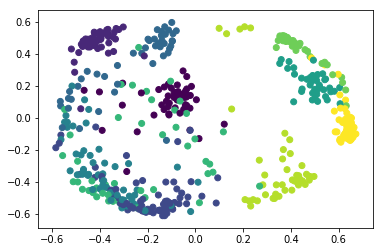

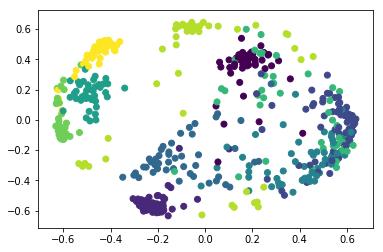

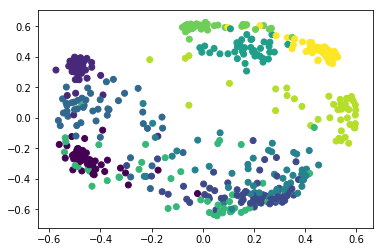

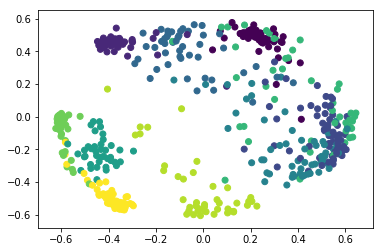

In [28]:
for i in sims_all_l1:
    weights_transform=mds.fit_transform(i)
    plt.scatter(weights_transform[:,0], weights_transform[:,1], c=test_labels[:500])
    plt.show()

In [29]:
mds = MDS(n_components=2, dissimilarity='cosine')

for i in weights_all_l1:
    weights_transform=mds.fit_transform(i)
    plt.scatter(weights_transform[:,0], weights_transform[:,1], c=test_labels[:500])
    plt.show()

ValueError: Proximity must be 'precomputed' or 'euclidean'. Got cosine instead

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=90, n_components=2, init='random', n_iter=5000)
lowD_1 = tsne.fit_transform(sims_all_l1[0])

In [ ]:
plt.scatter(lowD_1[:, 0],lowD_1[:, 1], c=test_labels[:500])

In [ ]:
tsne.set_params(metric="precomputed")
lowD_1_precomputed = tsne.fit_transform(sims_all_l1[0])

In [ ]:
plt.scatter(lowD_1_precomputed[:, 0],lowD_1_precomputed[:, 1], c=test_labels[:500])

## Neighbourhood Comparison
Seems to work better for the smaller layers, so I can't imagine the conv layers getting anything any better because their size will blow up even more. 

In [34]:
l2_e0_df = pd.DataFrame(weights_e0_l2)
l2_e0_df["cluster"] = test_labels[:500]
l2_e0_df.head()

,0,1,2,3,4,5,6,7,8,9,cluster
0,-2.832564,-3.108580,-3.353021,-5.498190,-3.887829,5.274677,-3.202466,3.060249,-0.916253,9.123307,9
1,-3.571748,-5.457707,6.346427,-5.213086,1.554488,-6.128864,3.183439,-11.687778,-4.269847,-8.848619,2
2,-0.781620,11.671178,-2.583724,0.870674,0.061486,-6.760188,0.595143,-7.774570,-2.866670,-5.840811,1
3,-1.180434,10.336160,-4.252085,3.711657,-2.218460,-5.324226,0.283187,-5.886521,-1.828279,-3.997019,1
4,1.503383,-4.844514,0.531549,-0.406060,-0.001760,-2.936786,2.753671,-4.754860,-0.947137,-4.094942,6


In [35]:
"""
    make_sim_matrix is an [n_samples, n_samples] matrix of parwise similarities. 
    X: the [n_samples, n_features] matrix from which to genarate the similarities. 
    Method: the method for computing pairwise similarities. Default is cosine. If "precomputed", returns X. 
"""
def make_sim_matrix(X, method="cosine"):
    sim_matrix = []
    
    if method == "cosine": 
        sim_matrix = np.array(cosine_similarity(X))
    elif method == "precomputed":
        sim_matrix = np.array(X)
    
    #ensure the diagonal is 1
    for i in range(len(sim_matrix)): 
        sim_matrix[i][i] = round(sim_matrix[i][i])
        #sim_matrix[i] = (list(map(lambda x: 1-x, sim_matrix[i])))
        
    return sim_matrix

In [36]:
"""
    get_nh returns the neighborhood value of a point, ie the % of the k nearest points 

"""
def get_nh(sim_matrix, feature_matrix, row_index, k=5):
    row = feature_matrix.iloc[row_index, :]
    # Remove any of the diagonal values
    filtered = list(filter(lambda x: x!=1, sim_matrix[row_index]))
    #Get the top k neighbors
    top = np.sort(filtered)[-k:]
    #print(top)
    clusters = []
    for i in range(len(sim_matrix[row_index])): 
        if sim_matrix[row_index][i] in top: 
            #rint(l2_e1_df.iloc[i, 10])
            clusters.append(feature_matrix.iloc[i, -1])
    #print(clusters)
    # Get the cluster of the original vector
    i_cluster = row[-1]
    #print(row)
    # Get the proprotion of the neighbors that are in the same cluster. 
    return len(list(filter(lambda x: x== i_cluster, clusters))) / len(clusters)

def average_nh(feature_matrix):
    sim_matrix = make_sim_matrix(feature_matrix.iloc[:, :10].values)
    avg = 0
    for i in range(len(feature_matrix)):
        avg += get_nh(sim_matrix, feature_matrix, i)
    return avg / len(feature_matrix)

In [37]:
l2_e0_sim = make_sim_matrix(l2_e0_df)
get_nh(l2_e0_sim, l2_e0_df, 0)

1.0

In [38]:
average_nh(l2_e0_df)

0.7924000000000003

In [39]:
for epoch in weights_all_l2: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))

0.7924000000000003
0.8024000000000004
0.8048000000000004
0.808400000000001


In [40]:
for epoch in weights_all_l1: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))

0.320809503756807
0.2770316374628625
0.31902337534096614
0.22269506191960417


In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=90, n_components=2, init='random', n_iter=5000)
lowD_1 = tsne.fit_transform(weights_e0_l1[:500])
#plot_with_labels(lowD_1, test_labels[:100])
lowD_all_1.append(lowD_1)

tsne.set_params(init=lowD_1)
for i in range(1, len(weights_all_l1)):
    lowD_1_i = tsne.fit_transform(weights_all_l1[i][:500])
    lowD_all_1.append(lowD_1_i)

/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neighbors/base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neighbors/base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neighbors/base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind
/home/linneamay/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neighbors/base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


In [51]:
tsne = TSNE(perplexity=30, n_components=2, init='random', n_iter=5000)
lowD_2_1 = tsne.fit_transform(weights_e0_l2[:500])
#plot_with_labels(lowD_1, test_labels[:100])
lowD_all.append(lowD_2_1)

tsne.set_params(init=lowD_2_1)
for i in range(1, len(weights_all_l2)):
    lowD_2_i = tsne.fit_transform(weights_all_l2[i][:500])
    lowD_all.append(lowD_2_i)

In [52]:
for epoch in lowD_all_1: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))

0.8212000000000012
0.8948000000000004
0.8728000000000009
0.8124000000000005
0.8520000000000006


In [53]:
for epoch in lowD_all: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))

0.9180000000000009
0.826000000000001
0.8868000000000006
0.8564000000000002
0.8538000000000006
